In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta  # Technical Analysis library
from functools import partial

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import keras
from keras import backend
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Attention, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle
import mlflow
import time
import logging

import optuna
import optuna.visualization as vis
from optuna.pruners import MedianPruner

# Time-Series-Forecasting

## 1. Initial Data Loading and Cleaning

The historical Bitcoin price data were downloaded from the **Coinbase API**. The dataset contains the price data for **1 year**, from **January 2024** to **January 2025**.

In [2]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume
0,2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
1,2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2,2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
3,2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
4,2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...,...
527180,2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352
527181,2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341
527182,2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781
527183,2025-01-23 23:59:00,103900.00,103973.87,103964.62,103926.36,6.802193


In [3]:
# btc_price_data_1_year = btc_price_data_1_year[:10000]
# btc_price_data_1_year

In [4]:
def load_and_clean_data(df):
    df_copy = df.copy()
    
    # Convert timestamp to datetime if it isn't already
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    # Set timestamp as index
    df_copy.set_index('timestamp', inplace=True, drop = True)
    
    # Sort by timestamp to ensure proper order
    df_copy = df_copy.sort_index()
    
    # Check for and handle any missing values
    df_copy = df_copy.dropna()
    
    return df_copy

In [5]:
btc_price_data_1_year = load_and_clean_data(btc_price_data_1_year)

In [6]:
btc_price_data_1_year

,open,high,low,close,volume
timestamp,,,,,
2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...
2024-01-31 22:02:00,42420.16,42451.00,42425.24,42451.00,7.068808
2024-01-31 22:03:00,42427.79,42456.86,42446.18,42430.09,4.379217
2024-01-31 22:04:00,42402.66,42432.58,42427.77,42408.60,2.724979


In [7]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,10000.0,41937.756808,1176.398866,39503.000000,41600.060000,42101.955000,42910.862500,43779.560000
high,10000.0,41965.215445,1178.875617,39544.660000,41625.325000,42119.255000,42936.222500,43872.990000
low,10000.0,41951.433600,1177.610554,39533.470000,41613.905000,42111.565000,42923.575000,43843.600000
close,10000.0,41951.829143,1177.500059,39533.480000,41615.880000,42111.355000,42923.060000,43850.580000
volume,10000.0,8.445071,14.580559,0.042391,1.516104,3.361168,8.535135,299.323667


In [8]:
btc_price_data_1_year.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [9]:
btc_price_data_1_year.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### 1.2. Plot Bitcoin Price

In [10]:
def plot_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    x_lim_start = dates[0]
    x_lim_end = dates[len(dates) - 1]
    # plt.xlim(x_lim_start, x_lim_end)
    ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates, prices)
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

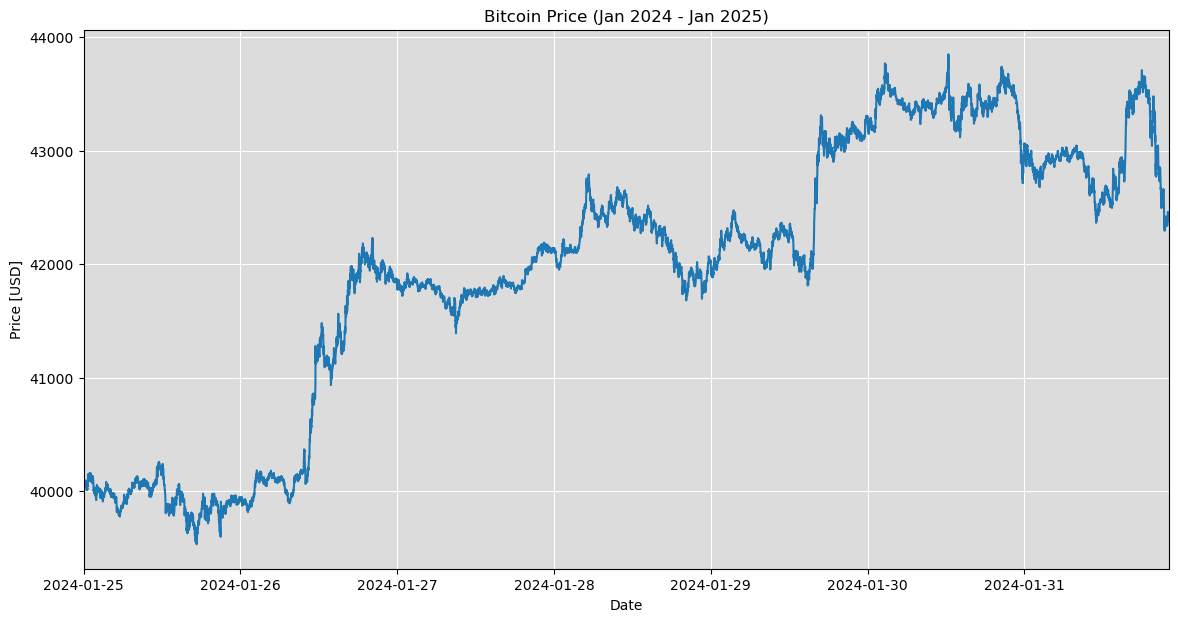

In [11]:
dates = btc_price_data_1_year.index
prices_close_btc = btc_price_data_1_year.close
title_btc = 'Bitcoin Price (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_market_data(dates, prices_close_btc, labels, title_btc)

In [12]:
# Configure the display settings of pandas so that all columns of a DataFrame are shown when printed.
pd.set_option('display.max_columns', None)

## 2. Feature Engineering

### 2.1. Calculate Technical Indicators

In [13]:
def add_technical_indicators(df):
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Basic price indicators
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close']/df['close'].shift(1))
    
    # Volume indicators
    df['volume_ma'] = df['volume'].rolling(window=24).mean()  # 24-hour moving average
    df['volume_std'] = df['volume'].rolling(window=24).std()
    
    # Trend indicators
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_20'] = df['close'].ewm(span=20).mean()
    
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['close'])
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_mid'] = bollinger.bollinger_mavg()

    # Average True Range (ATR)
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()
    
    # On-Balance Volume (OBV)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    
    return df

In [14]:
btc_price_data_1_year = add_technical_indicators(btc_price_data_1_year)

In [15]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,10000.0,41937.756808,1176.398866,39503.000000,41600.060000,42101.955000,42910.862500,43779.560000
high,10000.0,41965.215445,1178.875617,39544.660000,41625.325000,42119.255000,42936.222500,43872.990000
low,10000.0,41951.433600,1177.610554,39533.470000,41613.905000,42111.565000,42923.575000,43843.600000
close,10000.0,41951.829143,1177.500059,39533.480000,41615.880000,42111.355000,42923.060000,43850.580000
volume,10000.0,8.445071,14.580559,0.042391,1.516104,3.361168,8.535135,299.323667
returns,9999.0,0.000006,0.000545,-0.004260,-0.000259,0.000003,0.000265,0.007984
log_returns,9999.0,0.000006,0.000545,-0.004269,-0.000259,0.000003,0.000265,0.007952
volume_ma,9977.0,8.449421,10.535376,0.626881,2.502218,4.102344,9.642253,73.702226
volume_std,9977.0,6.755064,7.800856,0.411530,2.098824,3.594439,8.222606,64.018045
sma_20,9981.0,41953.184673,1176.375698,39594.162500,41613.017500,42115.279500,42929.157500,43695.193000


### 2.2. Add Time-Based Features

We extract various components of the datetime, such as the **month**, **day_of_month**, **hour**, and **day_of_week**. This can help the model capture seasonality and trends.

For time-based features like **hour** and **day_of_week**, we can use **cyclical encoding**. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [16]:
def add_temporal_features(df):
    df = df.copy()
    
    # Extract time components
    # df['hour'] = df.index.hour
    # df['day_of_week'] = df.index.weekday
    # df['day_of_month'] = df.index.day
    # df['month'] = df.index.month
    
    # Create cyclical features for time components
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)  # Hour sin encoding
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)  # Hour cos encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.weekday / 7)  # Weekday sin encoding
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.weekday / 7)  # Weekday cos encoding
    
    return df

In [17]:
btc_price_data_1_year = add_temporal_features(btc_price_data_1_year)

In [18]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns',
       'volume_ma', 'volume_std', 'sma_20', 'sma_50', 'ema_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_high', 'bb_low', 'bb_mid', 'atr', 'obv',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [19]:
# btc_price_data_1_year[['hour', 'day_of_week', 'day_of_month', 'month']][300000:300050]

In [20]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,10000.0,41937.756808,1176.398866,39503.000000,41600.060000,4.210196e+04,42910.862500,43779.560000
high,10000.0,41965.215445,1178.875617,39544.660000,41625.325000,4.211926e+04,42936.222500,43872.990000
low,10000.0,41951.433600,1177.610554,39533.470000,41613.905000,4.211157e+04,42923.575000,43843.600000
close,10000.0,41951.829143,1177.500059,39533.480000,41615.880000,4.211135e+04,42923.060000,43850.580000
volume,10000.0,8.445071,14.580559,0.042391,1.516104,3.361168e+00,8.535135,299.323667
returns,9999.0,0.000006,0.000545,-0.004260,-0.000259,3.106014e-06,0.000265,0.007984
log_returns,9999.0,0.000006,0.000545,-0.004269,-0.000259,3.106009e-06,0.000265,0.007952
volume_ma,9977.0,8.449421,10.535376,0.626881,2.502218,4.102344e+00,9.642253,73.702226
volume_std,9977.0,6.755064,7.800856,0.411530,2.098824,3.594439e+00,8.222606,64.018045
sma_20,9981.0,41953.184673,1176.375698,39594.162500,41613.017500,4.211528e+04,42929.157500,43695.193000


### 2.3. Seasonality and Trends

#### 2.3.1. STL (Seasonal-Trend decomposition using LOESS)

**STL** stands for **Seasonal-Trend decomposition using LOESS**. It's a robust statistical method used to decompose a time series into three components:

1. **Seasonal Component**: Represents the repeating pattern in the data over a fixed period (e.g., daily, weekly, monthly).
2. **Trend Component**: Captures the long-term progression in the data, showing an overall increase, decrease, or stability over time.
3. **Remainder/Residual Component**: Represents the part of the data that cannot be attributed to either seasonality or trend, often considered as noise.

**Key Features of STL**
- **Flexible**: Allows decomposition of time series with any type of seasonal pattern, not limited to a fixed frequency.
- **Robust**: Resistant to outliers in the data.
- **Local Regression (LOESS)**: Uses locally weighted regression to smooth the data during decomposition.

**Applications**
- **Forecasting**: By isolating the trend and seasonal components, forecasting models can be more accurate.
- **Anomaly Detection**: The remainder component helps identify unusual spikes or dips.
- **Visualization**: Simplifies understanding of the data by breaking it into interpretable parts.

In [21]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], robust=True, period = 24)  # period=24 for daily seasonality in hourly data
result = stl.fit()

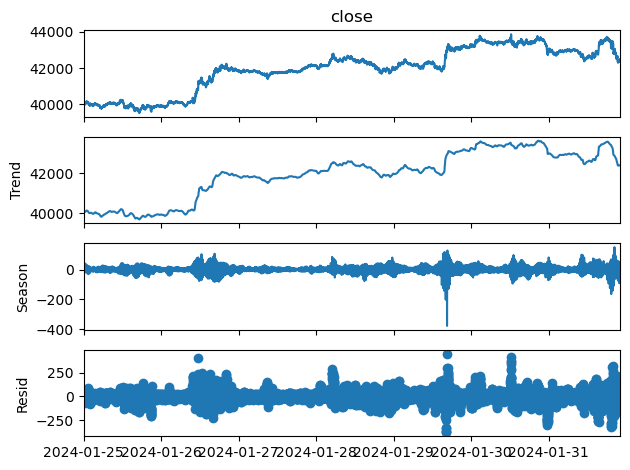

In [22]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
# btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition
result.plot()
plt.show()

### **TODO**
**Multicollinearity**: Be mindful of multicollinearity, which is when your **features are highly correlated** with each other.  This can make it difficult for your model to learn the individual effects of each feature.  Check the **correlation matrix** of your features.  If you find high correlations (especially **between lagged features**), you might need to **remove some features or use dimensionality reduction techniques like PCA**.

In [23]:
# 1.Rolling Statistics - Rolling mean and standard deviation of each component.
btc_price_data_1_year['trend_rolling_mean'] = btc_price_data_1_year['trend'].rolling(window=24).mean()
btc_price_data_1_year['trend_rolling_std'] = btc_price_data_1_year['trend'].rolling(window=24).std()
# btc_price_data_1_year['residual_rolling_std'] = btc_price_data_1_year['residual'].rolling(window=24).std()

# 2.Differences - Calculate the difference between close price and its trend or seasonality
btc_price_data_1_year['close_trend_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['trend']
btc_price_data_1_year['close_seasonal_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['seasonal']

#### 2.3.2. Rolling Statistics

Rolling mean and standard deviation help capture local trends and volatility.

In [24]:
# Rolling windows in hours
windows = [3, 6, 24]

In [25]:
for window in windows:
    # Rolling statistics for 'close' price
    btc_price_data_1_year[f'close_roll_mean_{window}'] = btc_price_data_1_year['close'].rolling(window=window).mean()
    btc_price_data_1_year[f'close_roll_std_{window}'] = btc_price_data_1_year['close'].rolling(window=window).std()
    
    # Volume-based rolling statistics
    btc_price_data_1_year[f'volume_roll_mean_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).mean()
    btc_price_data_1_year[f'volume_roll_std_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).std()

    # Get relationships between price and volume changes.
    btc_price_data_1_year[f'close_volume_interaction_{window}'] = btc_price_data_1_year[f'close_roll_mean_{window}'] * btc_price_data_1_year[f'volume_roll_mean_{window}']


### 2.3. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


#### 2.3.1. Autocorrelation Function (ACF)

Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [26]:
# We use the last day (24 hours) for the autocorrelation analysis
lags = 24

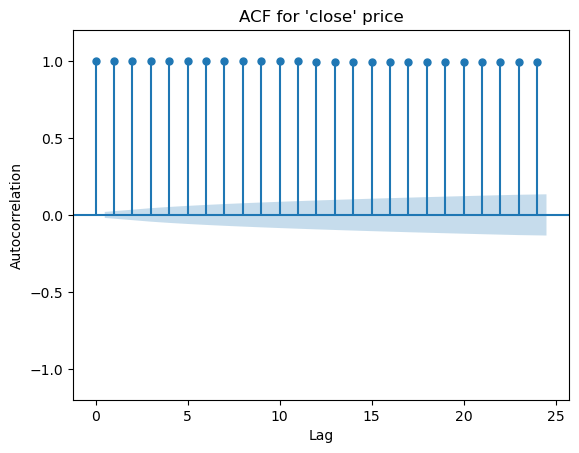

In [27]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

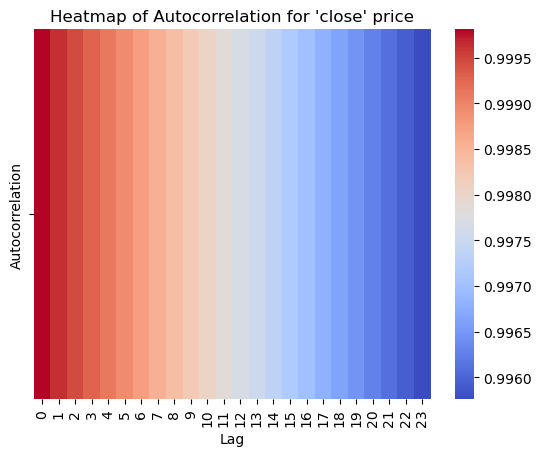

In [28]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

Because the **autocorrelation** is very large we use **partial autocorrelation**.

#### 2.3.2. Partial Autocorrelation Function (PACF)

The **Partial Autocorrelation Function (PACF)** measures the partial correlation of a stationary time series with its own lagged values, accounting for the influence of intermediate lags. Unlike the **Autocorrelation Function (ACF)**, which considers all previous lags, the PACF isolates the direct relationship between a variable and its lags.

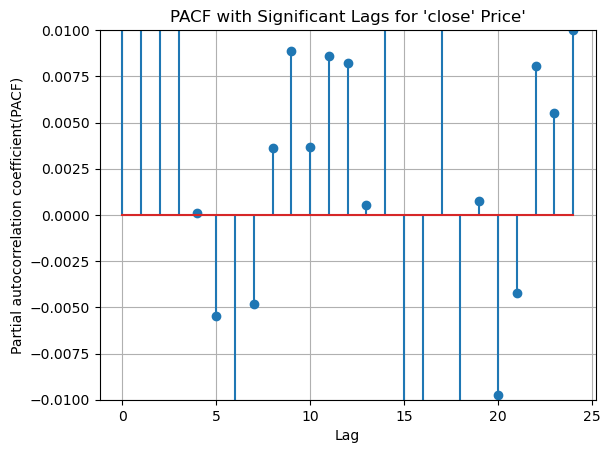

Significant Lags: [ 0  1  3 17 18]


In [29]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [30]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  3 17 18]


In [31]:
# Create lag features (past values as features)
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features)
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
        # Create lagged values of the trend and seasonal
        df_copy[f'trend_lag_{lag}'] = df_copy['trend'].shift(lag)
        df_copy[f'seasonal_lag_{lag}'] = df_copy['seasonal'].shift(lag)

        # Create lagged values of the difference between close price and its trend or seasonality
        df_copy[f'close_trend_diff_lag_{lag}'] = df_copy['close_trend_diff'].shift(lag)
        df_copy[f'close_seasonal_diff_lag_{lag}'] = df_copy['close_seasonal_diff'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [32]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

### 2.4. Calculate Target Variable

The **target** variable will be derived from the calculated **future returns**. The values of this variable are used as **buy/sell signals** for the traiding strategy. 

There will be 2 target values:
* 0  - price falls
* 1  - price rises

In [33]:
def create_target(df, forecast_horizon=1):
    df = df.copy()
    
    # Calculate future returns
    df['future_return'] = df['close'].shift(-forecast_horizon) / df['close'] - 1
    
    # Create binary target (1 for price up, 0 for price down)
    df['target'] = (df['future_return'] > 0).astype(int)

    print(df['target'].value_counts())
    
    return df

In [34]:
# Target: Next hour's close price
btc_price_data_1_year = create_target(btc_price_data_1_year, 1)

target
1    5048
0    4952
Name: count, dtype: int64


### 2.5. Clean up the Data

There are some rows in the dataset that have a `NaN` values (`future_return`, `RSI`, `SMA` and some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [35]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [36]:
btc_price_data_1_year.shape

(9950, 68)

In [37]:
btc_price_data_1_year.isnull().sum()

open                          0
high                          0
low                           0
close                         0
volume                        0
                             ..
seasonal_lag_18               0
close_trend_diff_lag_18       0
close_seasonal_diff_lag_18    0
future_return                 0
target                        0
Length: 68, dtype: int64

In [38]:
btc_price_data_1_year.dtypes

open                          float64
high                          float64
low                           float64
close                         float64
volume                        float64
                               ...   
seasonal_lag_18               float64
close_trend_diff_lag_18       float64
close_seasonal_diff_lag_18    float64
future_return                 float64
target                          int32
Length: 68, dtype: object

In [39]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns',
       'volume_ma', 'volume_std', 'sma_20', 'sma_50', 'ema_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_high', 'bb_low', 'bb_mid', 'atr', 'obv',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'trend',
       'seasonal', 'trend_rolling_mean', 'trend_rolling_std',
       'close_trend_diff', 'close_seasonal_diff', 'close_roll_mean_3',
       'close_roll_std_3', 'volume_roll_mean_3', 'volume_roll_std_3',
       'close_volume_interaction_3', 'close_roll_mean_6', 'close_roll_std_6',
       'volume_roll_mean_6', 'volume_roll_std_6', 'close_volume_interaction_6',
       'close_roll_mean_24', 'close_roll_std_24', 'volume_roll_mean_24',
       'volume_roll_std_24', 'close_volume_interaction_24', 'lag_1',
       'trend_lag_1', 'seasonal_lag_1', 'close_trend_diff_lag_1',
       'close_seasonal_diff_lag_1', 'lag_3', 'trend_lag_3', 'seasonal_lag_3',
       'close_trend_diff_lag_3', 'close_s

#### 2.6 Save Dataset

In [40]:
def save_data(df, filename='bitcoin_historical_data.csv'):
    """
    Saves data with a backup file
    """
    # Save file
    # df.to_csv(filename, index=False)
    df.to_csv(filename)
    
    print(f"Data saved to {filename}")

In [41]:
# Save the preprocessed dataset to a csv file
save_data(btc_price_data_1_year, filename = 'data/btc_price_data_1_year_prepocessed.csv')

Data saved to data/btc_price_data_1_year_prepocessed.csv


## 3. Data Preprocessing

Load the prepared dataset:

In [42]:
btc_price_data_1_year = pd.read_csv("data/btc_price_data_1_year_prepocessed.csv")
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)
btc_price_data_1_year

,open,high,low,close,volume,returns,log_returns,volume_ma,volume_std,sma_20,sma_50,ema_20,rsi,macd,macd_signal,macd_diff,bb_high,bb_low,bb_mid,atr,obv,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,trend,seasonal,trend_rolling_mean,trend_rolling_std,close_trend_diff,close_seasonal_diff,close_roll_mean_3,close_roll_std_3,volume_roll_mean_3,volume_roll_std_3,close_volume_interaction_3,close_roll_mean_6,close_roll_std_6,volume_roll_mean_6,volume_roll_std_6,close_volume_interaction_6,close_roll_mean_24,close_roll_std_24,volume_roll_mean_24,volume_roll_std_24,close_volume_interaction_24,lag_1,trend_lag_1,seasonal_lag_1,close_trend_diff_lag_1,close_seasonal_diff_lag_1,lag_3,trend_lag_3,seasonal_lag_3,close_trend_diff_lag_3,close_seasonal_diff_lag_3,lag_17,trend_lag_17,seasonal_lag_17,close_trend_diff_lag_17,close_seasonal_diff_lag_17,lag_18,trend_lag_18,seasonal_lag_18,close_trend_diff_lag_18,close_seasonal_diff_lag_18,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-25 00:49:00,40096.06,40117.78,40096.06,40109.60,10.527911,0.000341,0.000341,9.599183,6.414985,40080.4245,40063.4206,40090.375072,56.858930,17.426433,16.994612,0.431821,40176.685915,39984.163085,40080.4245,13.980711,-12.766038,0.0,1.000000,0.433884,-0.900969,40115.033816,-8.071918,40081.909710,21.026089,-5.433816,40117.671918,40100.623333,7.776994,6.388110,3.601780,256167.191051,40107.061667,19.183734,9.010085,4.904713,361368.018407,40069.088750,51.836342,9.599183,6.414985,384630.523234,40095.92,40113.103076,-9.125366,-17.183076,40105.045366,40107.20,40108.481482,-4.888623,-1.281482,40112.088623,40014.77,40063.575909,-2.590716,-48.805909,40017.360716,40011.26,40061.125234,-15.339726,-49.865234,40026.599726,2.592895e-04,1
2024-01-25 00:50:00,40099.42,40120.00,40109.59,40120.00,4.440333,0.000259,0.000259,8.592098,5.053382,40084.7810,40064.7846,40093.213727,59.054379,17.628187,17.121327,0.506860,40179.919329,39989.642671,40084.7810,13.725660,-8.325705,0.0,1.000000,0.433884,-0.900969,40116.736827,-14.278920,40084.581414,21.214954,3.263173,40134.278920,40108.506667,12.077174,6.313659,3.657131,253231.426606,40103.193333,11.054345,7.147957,3.918131,286655.895293,40073.326667,51.660072,8.592098,5.053382,344313.941524,40109.60,40115.033816,-8.071918,-5.433816,40117.671918,40096.35,40110.923529,-6.769081,-14.573529,40103.119081,40022.89,40066.250107,-4.032655,-43.360107,40026.922655,40014.77,40063.575909,-2.590716,-48.805909,40017.360716,-4.349452e-04,0
2024-01-25 00:51:00,40102.55,40121.45,40116.87,40102.55,3.447542,-0.000435,-0.000435,8.493151,5.132602,40089.3455,40065.5972,40094.107807,54.081290,16.193342,16.935730,-0.742388,40178.508514,40000.182486,40089.3455,13.072398,-11.773246,0.0,1.000000,0.433884,-0.900969,40118.234817,-15.735953,40087.266997,21.225996,-15.684817,40118.285953,40110.716667,8.778430,6.138595,3.833533,246223.459350,40105.270000,9.097626,5.477551,2.597781,219678.650631,40077.190833,50.148833,8.493151,5.132602,340381.633086,40120.00,40116.736827,-14.278920,3.263173,40134.278920,40095.92,40113.103076,-9.125366,-17.183076,40105.045366,40015.81,40069.129515,19.145085,-53.319515,39996.664915,40022.89,40066.250107,-4.032655,-43.360107,40026.922655,1.780435e-04,1
2024-01-25 00:52:00,40097.26,40113.46,40101.91,40109.69,3.290059,0.000178,0.000178,8.310886,5.239860,40094.0915,40066.9346,40095.599237,55.724252,15.454209,16.639426,-1.185217,40176.737877,40011.445123,40094.0915,12.963656,-8.483187,0.0,1.000000,0.433884,-0.900969,40119.547080,-14.743984,40089.947064,21.064545,-9.857080,40124.433984,40110.746667,8.772858,3.725978,0.623641,149451.762585,40105.685000,9.258641,5.057044,2.733273,202816.214230,40081.365417,48.408910,8.310886,5.239860,333111.640632,40102.55,40118.234817,-15.735953,-15.684817,40118.285953,40109.60,40115.033816,-8.071918,-5.433816,40117.671918,40034.50,40072.191459,2.528313,-37.691459,40031.971687,40015.81,40069.129515,19.145085,-53.319515,39996.664915,6.282771e-04,1
2024-01-25 00:53:00,

### 3.1. One-hot encoding for categorical features

In [43]:
# btc_price_data_1_year = pd.get_dummies(btc_price_data_1_year, columns=['day_of_week', 'day_of_month', 'month'], drop_first=True) # drop_first to avoid multicollinearity

In [44]:
# btc_price_data_1_year.columns

### 3.2. Split the Dataset

Typically, for time series, the data is split chronologically to avoid data leakage. For example:
- **Training set**: 80% of the data (used for training the model).
- **Validation set**: 10% of the data (used for hyperparameter tuning).
- **Test set**: 10% of the data (used to evaluate final performance).

In [45]:
# Sort the dataset by time to maintain chronological order
# btc_price_data_1_year = btc_price_data_1_year.sort_values(by='timestamp')  # Replace 'timestamp' with your time column if named differently

# # Split the dataset into train, validation, and test sets
# train_size = 0.8
# val_size = 0.1
# test_size = 0.1

# # Compute split indices
# train_idx = int(len(btc_price_data_1_year) * train_size)
# val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# # Split the data
# btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
# btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
# btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]

# Split data
X = btc_price_data_1_year.drop('target', axis=1)
y = btc_price_data_1_year['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# print(f"Training set: {len(btc_price_data_1_year_train)} rows")
# print(f"Validation set: {len(btc_price_data_1_year_val)} rows")
# print(f"Test set: {len(btc_price_data_1_year_test)} rows")

print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Test set: {len(X_test)} rows")

Training set: 7960 rows
Validation set: 995 rows
Test set: 995 rows


In [46]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(target
 1    4037
 0    3923
 Name: count, dtype: int64,
 target
 0    504
 1    491
 Name: count, dtype: int64,
 target
 0    502
 1    493
 Name: count, dtype: int64)

In [47]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

In [48]:
# dates_train = btc_price_data_1_year_train.index
# prices_close_train = btc_price_data_1_year_train.close

# dates_val = btc_price_data_1_year_val.index
# prices_close_val = btc_price_data_1_year_val.close

# dates_test = btc_price_data_1_year_test.index
# prices_close_test = btc_price_data_1_year_test.close

# dates = [dates_train, dates_val, dates_test]
# prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

# title_btc = 'Data Split (Jan 2024 - Jan 2025)'

# labels = ['Date', 'Price [USD]']

# plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

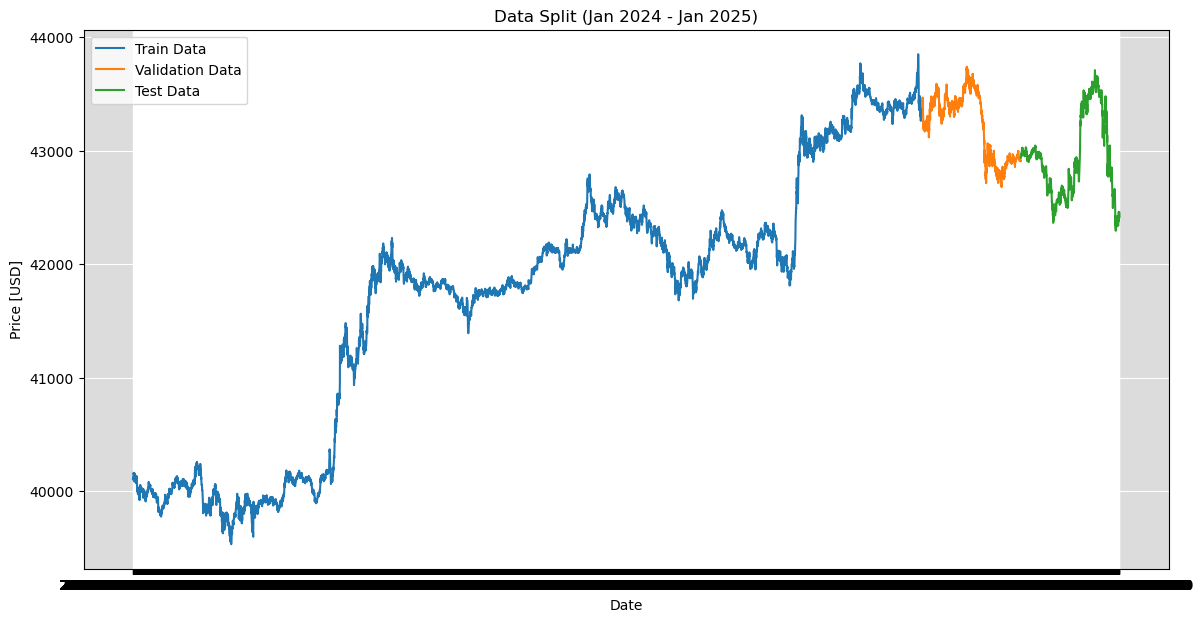

In [49]:
dates_train = X_train.index
prices_close_train = X_train.close

dates_val = X_val.index
prices_close_val = X_val.close

dates_test = X_test.index
prices_close_test = X_test.close

dates = [dates_train, dates_val, dates_test]
prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

title_btc = 'Data Split (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 3.3. Scale Features

1. Define the features to scale (numerical columns).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [50]:
# Exclude already normalized features like 'hour_sin'/'hour_cos'
# features_to_exclude = ['hour_sin', 'hour_cos','day_of_week_sin', 'day_of_week_cos']
# features_to_exclude = [['hour_sin', 'hour_cos','day_sin', 'day_cos']]
# Exclude already normalized features like 'hour_sin'/'hour_cos' and the 'target'('target' is categorical variable)
# features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'target']

features_to_exclude = []
for x in btc_price_data_1_year.columns:
    if x.startswith('day_of_week') or x.startswith('day_of_month') or x.startswith('month') or x.startswith('hour') or x.startswith('target'):
        features_to_exclude.append(x)

# Select the remaining columns
numericel_features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Scale selected features
# scaler = StandardScaler()
X_train_scaled = X_train.copy() 
X_val_scaled = X_val.copy() 
X_test_scaled = X_test.copy()

# Fit the scaler ONLY on the training set and transform all sets
X_train_scaled[numericel_features_to_scale] = scaler.fit_transform(X_train[numericel_features_to_scale])
X_val_scaled[numericel_features_to_scale] = scaler.transform(X_val[numericel_features_to_scale])
X_test_scaled[numericel_features_to_scale] = scaler.transform(X_test[numericel_features_to_scale])

# # Convert back to DataFrames (optional but recommended for easier handling)
# X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# # Fit the scaler ONLY on the training set and transform all sets
# btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
# btc_price_data_1_year_val.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_val[features_to_scale])
# btc_price_data_1_year_test.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_test[features_to_scale])

In [51]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
open,7960.0,-2.856453e-16,1.000063,-1.903213,-1.296206,0.203506,0.576181,1.858405
high,7960.0,5.712906e-17,1.000063,-1.888012,-1.290175,0.206558,0.573679,1.917390
low,7960.0,1.485356e-15,1.000063,-1.887296,-1.293916,0.204095,0.574269,1.903681
close,7960.0,-3.999034e-15,1.000063,-1.887694,-1.291773,0.204032,0.573814,1.909224
volume,7960.0,-4.284680e-17,1.000063,-0.549237,-0.448374,-0.336486,-0.028553,17.831211
...,...,...,...,...,...,...,...,...
trend_lag_18,7960.0,2.456550e-15,1.000063,-1.758536,-1.322600,0.211218,0.578893,1.706943
seasonal_lag_18,7960.0,-1.896863e-18,1.000063,-19.136601,-0.448925,-0.003643,0.446467,6.451216
close_trend_diff_lag_18,7960.0,5.355850e-18,1.000063,-6.650724,-0.433430,-0.040911,0.387593,9.523784
close_seasonal_diff_lag_18,7960.0,2.970711e-15,1.000063,-1.892268,-1.307969,0.207514,0.574811,1.921201


### 3.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, you typically convert the flat features into sequences.

In [52]:
def create_sequences(X, y, timesteps):
    # Convert inputs to numpy arrays if they're not already
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = np.array(X)
    if hasattr(y, 'values'):
        y_array = y.values
    else:
        y_array = np.array(y)
    
    # Ensure X_array has shape (samples, num_features)
    # If not, adjust (for example, if it is transposed)
    if X_array.shape[0] < X_array.shape[1]:
        X_array = X_array.T

    # Create the sliding window view along the time axis (axis=0)
    X_seq = np.lib.stride_tricks.sliding_window_view(X_array, window_shape=timesteps, axis=0)
    # X_seq is expected to have shape (samples - timesteps + 1, timesteps, num_features)
    
    # Sometimes the window axis might appear in a different position,
    # so check if the last dimension matches the number of features.
    if X_seq.shape[-1] != X_array.shape[1]:
        # If not, swap the last two axes
        X_seq = np.swapaxes(X_seq, -1, -2)

    # Since the original loop created windows for indices timesteps to len(X)-1,
    # we take all but the last sliding window to match the target length.
    X_seq = X_seq[:-1]
    
    # The corresponding target values from y start at index `timesteps`
    y_seq = y_array[timesteps:]

    # Ensure both arrays have a numeric dtype (e.g., float32)
    X_seq = X_seq.astype(np.float32)
    y_seq = y_seq.astype(np.float32)
    
    return X_seq, y_seq

In [53]:
# Define the number of timesteps (sequence length) for LSTM
TIMESTEPS = 12 # Example: Look at the past 24 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIMESTEPS)
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")

X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIMESTEPS)
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")

X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIMESTEPS)
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (7948, 12, 67), y_train_seq shape: (7948,)
X_val_seq shape: (983, 12, 67), y_val_seq shape: (983,)
X_test_seq shape: (983, 12, 67), y_test_seq shape: (983,)


In [54]:
print(X_train_scaled.columns.values)

['open' 'high' 'low' 'close' 'volume' 'returns' 'log_returns' 'volume_ma'
 'volume_std' 'sma_20' 'sma_50' 'ema_20' 'rsi' 'macd' 'macd_signal'
 'macd_diff' 'bb_high' 'bb_low' 'bb_mid' 'atr' 'obv' 'hour_sin' 'hour_cos'
 'day_of_week_sin' 'day_of_week_cos' 'trend' 'seasonal'
 'trend_rolling_mean' 'trend_rolling_std' 'close_trend_diff'
 'close_seasonal_diff' 'close_roll_mean_3' 'close_roll_std_3'
 'volume_roll_mean_3' 'volume_roll_std_3' 'close_volume_interaction_3'
 'close_roll_mean_6' 'close_roll_std_6' 'volume_roll_mean_6'
 'volume_roll_std_6' 'close_volume_interaction_6' 'close_roll_mean_24'
 'close_roll_std_24' 'volume_roll_mean_24' 'volume_roll_std_24'
 'close_volume_interaction_24' 'lag_1' 'trend_lag_1' 'seasonal_lag_1'
 'close_trend_diff_lag_1' 'close_seasonal_diff_lag_1' 'lag_3'
 'trend_lag_3' 'seasonal_lag_3' 'close_trend_diff_lag_3'
 'close_seasonal_diff_lag_3' 'lag_17' 'trend_lag_17' 'seasonal_lag_17'
 'close_trend_diff_lag_17' 'close_seasonal_diff_lag_17' 'lag_18'
 'trend_lag_

In [55]:
X_train_scaled.describe()[['hour_sin', 'hour_cos','day_of_week_sin', 'day_of_week_cos']].T

,count,mean,std,min,25%,50%,75%,max
hour_sin,7960.0,0.057341,0.704232,-1.000000,-0.707107,1.224647e-16,0.707107,1.000000
hour_cos,7960.0,-0.006596,0.707708,-1.000000,-0.707107,6.123234e-17,0.707107,1.000000
day_of_week_sin,7960.0,-0.244434,0.592730,-0.974928,-0.781831,-4.338837e-01,0.433884,0.781831
day_of_week_cos,7960.0,-0.005690,0.767469,-0.900969,-0.900969,-2.225209e-01,0.623490,1.000000


## 4. Define Model Architecture

### 4.1. Model Definition

Create an advanced CNN-LSTM model architecture specifically designed for our data.

The model architecture includes:
   - Multiple CNN layers to capture patterns in technical indicators
   - Batch normalization to stabilize training
   - LSTM layers to capture temporal dependencies
   - Dropout for regularization
   - Dense layers for final prediction

In [56]:
# def create_cnn_lstm_model(input_shape, dropout_rate=0.1):
#     """
#     Creates a CNN-LSTM hybrid model optimized for cryptocurrency price prediction.
    
#     Parameters:
#     input_shape: Tuple of (sequence_length, n_features)
#     dropout_rate: Dropout rate for regularization
#     """
#     # Input layer
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # First CNN block - captures local patterns in technical indicators
#     # x = tf.keras.layers.Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(inputs)
#     # x = tf.keras.layers.BatchNormalization()(x)
#     # x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
#     x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)  # Added dropout
    
#     # Second CNN block - captures more complex patterns
#     # x = tf.keras.layers.Conv1D(filters=256,kernel_size=3,padding='same',activation='relu')(x)
#     # x = tf.keras.layers.BatchNormalization()(x)
#     # x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
#     x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)  # Added dropout
    
#     # LSTM layers - capture temporal dependencies
#     # x = tf.keras.layers.LSTM( units=256,return_sequences=True)(x)
#     # x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # x = tf.keras.layers.LSTM(units=128,return_sequences=False)(x)
#     # x = tf.keras.layers.Dropout(dropout_rate)(x)

#     x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(192, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
    
#     # Dense layers for final prediction
#     # x = tf.keras.layers.Dense(32, activation='relu')(x)
#     # x = tf.keras.layers.Dropout(dropout_rate)(x)

#     # Dense layers with L2 regularization
#     x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout for generalization
    
#     # Output layer - binary classification
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
#     # Create and compile model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
#     return model

In [57]:
# Attention Mechanism to improve feature importance weighting
@keras.saving.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        attention_scores = tf.nn.softmax(inputs, axis=1)  # Compute attention weights
        return tf.reduce_sum(inputs * attention_scores, axis=1)  # Weighted sum

In [58]:
def create_cnn_lstm_model(input_shape, params):
    """
    Creates a CNN-LSTM hybrid model optimized for cryptocurrency price prediction.
    
    Parameters:
    input_shape: Tuple of (sequence_length, n_features)
    dropout_rate: Dropout rate for regularization
    """
    dropout_rate = params['dropout_rate']
    lstm_units_1 = params['lstm_units_1']
    lstm_units_2 = params['lstm_units_2']
    lstm_units_3 = params['lstm_units_3']
    cnn_filters_1 = params['cnn_filters_1']
    cnn_filters_2 = params['cnn_filters_2']
    cnn_kernel_size = params['cnn_kernel_size']
    cnn_dropout = params['cnn_dropout']
    l2_reg = params['l2_reg']

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # First CNN block - captures local patterns in technical indicators
    x = tf.keras.layers.Conv1D(filters=cnn_filters_1, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x)  # Added dropout
    
    # Second CNN block - captures more complex patterns
    x = tf.keras.layers.Conv1D(filters=cnn_filters_2, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x)  # Added dropout
    
    # LSTM layers - capture temporal dependencies
    x = tf.keras.layers.LSTM(lstm_units_1, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_2, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_3, return_sequences=True)(x)

    # Attention Layer
    x = Attention()(x)
    
    # Dense layers with L2 regularization
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout for generalization
    
    # Output layer - binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

### 4.2. Train the model

The training process includes:
   - Early stopping to prevent overfitting
   - Learning rate reduction when progress stalls
   - Model checkpointing to save the best version
   - Multiple metrics to track performance

### 4.3. Evaluate the Model

These visualization and analysis tools will help you understand:
1. How well your model learned during training
2. Where your model performs well and where it struggles
3. If there are patterns in the prediction errors
4. How the model's performance varies across different time periods
5. The reliability of the model's probability estimates

#### Visualize the training history and model performance

In [59]:
def plot_training_history(history):
    """
    Visualizes the model's training history, showing how metrics evolved over epochs.
    """
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Analyze the model's predictions 

In [60]:
def get_optimal_treshold(y_test, y_pred_proba):
    # `y_test` are the true labels and `y_pred_probs` are the predicted probabilities from the model
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Find the optimal threshold (point with the highest TPR - FPR)
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [61]:
def analyze_predictions(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive analysis of model predictions including confusion matrix,
    ROC curve, and detailed metrics.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)

    if threshold == 0.5:
        # get optimal treshold
        threshold = get_optimal_treshold(y_test, y_pred_proba)

    print("current threshold: ", threshold)
    y_pred = (y_pred_proba >= threshold).astype(int)
        
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    
    # 3. Prediction Distribution
    sns.histplot(y_pred_proba, bins=50, ax=ax3)
    ax3.axvline(threshold, color='r', linestyle='--', 
                label=f'Threshold ({threshold})')
    ax3.set_title('Distribution of Prediction Probabilities')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # 4. Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    ax4.axis('off')
    ax4.table(cellText=report_df.round(3).values,
              rowLabels=report_df.index,
              colLabels=report_df.columns,
              cellLoc='center',
              loc='center')
    ax4.set_title('Classification Report')
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba, y_pred

#### Analyze prediction errors and identify patterns

In [62]:
def analyze_prediction_errors(model, X_test, y_test, processed_df, scaler, threshold=0.5):
    """
    Analyzes when and why the model makes incorrect predictions.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Create error analysis DataFrame
    error_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Probability': y_pred_proba.flatten(),
        'Error': y_test != y_pred.flatten()
    })
    
    # # Add relevant features from processed_df
    # # Note: You'll need to align the indices properly based on your data structure
    # error_analysis['Hour'] = processed_df['hour'].iloc[-len(y_test):]
    # error_analysis['Day_of_Week'] = processed_df['day_of_week'].iloc[-len(y_test):]
    
    # Create visualizations for error analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # # 1. Error rate by hour of day
    # error_by_hour = error_analysis[error_analysis['Error']].groupby('Hour').size() / \
    #                 error_analysis.groupby('Hour').size()

    # print(f'error_by_hour: {error_by_hour}')

    # if len(error_by_hour) > 0:
    #     error_by_hour.plot(kind='bar', ax=ax1)
    #     ax1.set_title('Error Rate by Hour of Day')
    #     ax1.set_xlabel('Hour')
    #     ax1.set_ylabel('Error Rate')
    
    # # 2. Error rate by day of week
    # error_by_day = error_analysis[error_analysis['Error']].groupby('Day_of_Week').size() / \
    #                error_analysis.groupby('Day_of_Week').size()
    # if len(error_by_day) > 0:
    #     error_by_day.plot(kind='bar', ax=ax2)
    #     ax2.set_title('Error Rate by Day of Week')
    #     ax2.set_xlabel('Day of Week')
    #     ax2.set_ylabel('Error Rate')
    
    # 3. Probability distribution for correct vs incorrect predictions
    sns.kdeplot(data=error_analysis, x='Probability', hue='Error', ax=ax3)
    ax3.set_title('Prediction Probability Distribution\nCorrect vs Incorrect Predictions')
    
    # 4. Confusion matrix with percentages
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax4)
    ax4.set_title('Confusion Matrix (Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    return error_analysis

#### Evaluate the model's performance over different time horizons

In [63]:
def evaluate_prediction_horizons(model, X_test, y_test, processed_df):
    """
    Evaluates how the model's performance varies over different prediction horizons.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Create DataFrames for analysis
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Timestamp': processed_df.index[-len(y_test):]
    })
    
    # Calculate rolling accuracy
    window_sizes = [24, 72, 168]  # 1 day, 3 days, 1 week
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot rolling accuracy for different windows
    for window in window_sizes:
        rolling_acc = (
            (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
            .rolling(window)
            .mean()
        )
        rolling_acc.plot(ax=ax1, label=f'{window}h Rolling Accuracy')
    
    ax1.set_title('Rolling Accuracy Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot cumulative accuracy
    cumulative_acc = (
        (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
        .cumsum() / range(1, len(predictions_df) + 1)
    )
    cumulative_acc.plot(ax=ax2)
    ax2.set_title('Cumulative Accuracy Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

#### Start Complete Analysis

In [64]:
def perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler):
    """
    Performs a complete analysis of the model's performance.
    """
    print("1. Analyzing training history...")
    plot_training_history(history)
    
    print("\n2. Analyzing predictions...")
    y_pred_proba, y_pred = analyze_predictions(model, X_test, y_test)
    
    print("\n3. Analyzing prediction errors...")
    error_analysis = analyze_prediction_errors(model, X_test, y_test, processed_df, scaler)
    
    print("\n4. Evaluating prediction horizons...")
    predictions_df = evaluate_prediction_horizons(model, X_test, y_test, processed_df)
    
    return {
        'predictions': predictions_df,
        'error_analysis': error_analysis,
        'probabilities': y_pred_proba,
        'predicted_classes': y_pred
    }

In [65]:
# Analysis results
# analysis_results = perform_complete_analysis(model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)

In [66]:
# def run_complete_pipeline(df):
#     # Split and scale data
#     (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, processed_df = split_and_scale_data(df)
    
#     # Get input shape from training data
#     input_shape = (X_train.shape[1], X_train.shape[2])
    
#     # Train model
#     model, history = train_model(X_train, y_train, X_val, y_val, input_shape, epochs = 1)
    
#     # Evaluate on test set
#     test_results = model.evaluate(X_test, y_test, verbose=0)
#     print("\nTest results:")
#     for metric, value in zip(model.metrics_names, test_results):
#         print(f"{metric}: {value:.4f}")

#     # Analysis results
#     analysis_results = perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler)
    
#     return model, history, scaler

<!-- I'll help you create comprehensive visualization and analysis tools to understand your model's performance. Let's break this down into different aspects of model analysis and create visualization functions for each.

First, let's create functions to visualize the training history and model performance:

```python
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np -->



### 4.4. Interpreting Visualizations and Metrics

To use these analysis tools effectively:

1. Start with the training history to identify basic fitting issues
2. Use the ROC curve and confusion matrix to understand classification performance
3. Analyze prediction distributions to understand model confidence
4. Look for temporal patterns in errors
5. Use the comprehensive analysis to get specific improvement recommendations

#### 1. Training History Plots

The training history plots show loss and accuracy curves for both training and validation sets.

When examining the curves, look for these patterns:
- If both training and validation loss are high and flat: The model is underfitting
- If training loss keeps decreasing but validation loss increases: The model is overfitting
- If both curves converge smoothly: The model has found a good balance

In [67]:
def interpret_training_curves(history):
    """
    Visualizes and analyzes training curves to identify learning patterns
    """
    plot_training_history(history)
    
    # Calculate key metrics for interpretation
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    loss_gap = final_val_loss - final_train_loss
    
    print("Training Pattern Analysis:")
    
    if final_train_loss > 0.3:  # This threshold can be adjusted
        print("High training loss suggests underfitting. Consider:")
        print("- Increasing model capacity (add more layers/neurons)")
        print("- Training for more epochs")
        print("- Reducing regularization (lower dropout rate)")
    
    if loss_gap > 0.1:  # This threshold can be adjusted
        print("\nLarge gap between training and validation loss suggests overfitting. Consider:")
        print("- Adding dropout layers")
        print("- Reducing model complexity")
        print("- Using early stopping")
        print("- Collecting more training data")

#### 2. Confusion Matrix and ROC Curve Analysis

In [68]:
def analyze_classification_metrics(model, X_test, y_test):
    """
    Analyzes classification metrics to identify model strengths and weaknesses
    """
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print("Model Performance Analysis:")
    
    # Analyze true positive rate and false positive rate
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])  # Sensitivity
    tnr = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity
    
    print(f"\nAUC Score: {roc_auc:.3f}")
    if roc_auc < 0.7:
        print("Low AUC suggests poor discriminative ability. Consider:")
        print("- Adding more relevant features")
        print("- Feature engineering")
        print("- Trying different model architectures")
    
    print(f"\nSensitivity (True Positive Rate): {tpr:.3f}")
    print(f"Specificity (True Negative Rate): {tnr:.3f}")
    
    # Analyze balance of predictions
    if abs(tpr - tnr) > 0.2:
        print("\nImbalanced prediction performance detected. Consider:")
        print("- Class weighting in model")
        print("- Adjusting decision threshold")
        print("- Addressing data imbalance")

#### 3. Prediction Distribution Analysis

In [69]:
def analyze_prediction_distribution(y_pred_proba, y_test):
    """
    Analyzes the distribution of prediction probabilities
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50)
    plt.axvline(0.5, color='r', linestyle='--', label='Default Threshold')
    plt.title('Distribution of Prediction Probabilities')
    plt.show()
    
    # Analyze prediction confidence
    low_confidence = np.mean((y_pred_proba > 0.4) & (y_pred_proba < 0.6))
    
    print("Prediction Confidence Analysis:")
    print(f"Proportion of low confidence predictions: {low_confidence:.3f}")
    
    if low_confidence > 0.3:
        print("\nHigh proportion of low confidence predictions. Consider:")
        print("- Adding more discriminative features")
        print("- Increasing model capacity")
        print("- Using ensemble methods")

#### 4. Error Analysis Over Time

In [70]:
def analyze_temporal_patterns(error_analysis):
    """
    Analyzes patterns in prediction errors over different time periods
    """
    # Analyze error rates by time period
    hourly_error_rate = error_analysis.groupby('Hour')['Error'].mean()
    # daily_error_rate = error_analysis.groupby('Day_of_Week')['Error'].mean()
    
    print("Temporal Pattern Analysis:")
    
    # Find hours with high error rates
    problem_hours = hourly_error_rate[hourly_error_rate > hourly_error_rate.mean() + hourly_error_rate.std()]
    if not problem_hours.empty:
        print("\nHigh error rates detected during hours:", problem_hours.index.tolist())
        print("Consider:")
        print("- Adding more features specific to these time periods")
        print("- Creating separate models for different time periods")
        print("- Adding more training data for these periods")
    
    # # Analyze weekly patterns
    # if daily_error_rate.std() > 0.1:
    #     print("\nSignificant variation in daily error rates detected. Consider:")
    #     print("- Adding more day-specific features")
    #     print("- Creating separate models for different days")

#### 5. Putting It All Together

In [71]:
def comprehensive_model_analysis(model, X_test, y_test, history, processed_df):
    """
    Performs comprehensive analysis and provides specific improvement recommendations
    """
    print("=== Comprehensive Model Analysis ===\n")
    
    # Analyze training patterns
    interpret_training_curves(history)
    
    print("\n=== Classification Performance ===")
    analyze_classification_metrics(model, X_test, y_test)
    
    # Get predictions for further analysis
    y_pred_proba = model.predict(X_test)
    print("\n=== Prediction Confidence Analysis ===")
    analyze_prediction_distribution(y_pred_proba, y_test)


    # # Create error analysis DataFrame
    # if 'hour' in processed_df.columns:
    #     error_analysis = pd.DataFrame({
    #         'Hour': processed_df['hour'].iloc[-len(y_test):],
    #         'Error': y_test != (y_pred_proba >= 0.5).astype(int).flatten()
    #     })
    # else:
    #     print("Warning: 'hour' column is missing in processed_df")
    #     error_analysis = pd.DataFrame({
    #         'Error': y_test != (y_pred_proba >= 0.5).astype(int).flatten()
    #     })

    
    # # Create error analysis DataFrame
    # error_analysis = pd.DataFrame({
    #     'Hour': processed_df['hour'].iloc[-len(y_test):],
    #     # 'Day_of_Week': processed_df['day_of_week'].iloc[-len(y_test):],
    #     'Error': y_test != (y_pred_proba >= 0.5).astype(int).flatten()
    # })
    
    # print("\n=== Temporal Pattern Analysis ===")
    # analyze_temporal_patterns(error_analysis)
    
    # # Final recommendations
    # print("\n=== Overall Recommendations ===")
    # compile_final_recommendations(history, y_pred_proba, error_analysis)

def compile_final_recommendations(history, y_pred_proba, error_analysis):
    """
    Compiles final recommendations based on all analyses
    """
    recommendations = []
    
    # Check for underfitting/overfitting
    if history.history['val_loss'][-1] > history.history['loss'][-1] * 1.1:
        recommendations.append("Model shows signs of overfitting:")
        recommendations.append("- Increase dropout rate")
        recommendations.append("- Add L1/L2 regularization")
        recommendations.append("- Reduce model complexity")
    
    # Check prediction confidence
    low_confidence = np.mean((y_pred_proba > 0.4) & (y_pred_proba < 0.6))
    if low_confidence > 0.3:
        recommendations.append("\nLow prediction confidence detected:")
        recommendations.append("- Consider ensemble methods")
        recommendations.append("- Add more feature engineering")
    
    # Check temporal patterns
    if error_analysis.groupby('Hour')['Error'].std().any() > 0.1:
        recommendations.append("\nSignificant temporal patterns detected:")
        recommendations.append("- Consider time-based feature engineering")
        recommendations.append("- Implement separate models for different time periods")
    
    print("\n".join(recommendations))

In [72]:
# Performs comprehensive analysis and provides specific improvement recommendations
# comprehensive_model_analysis(model, X_test_seq, y_test_seq, history, btc_price_data_1_year)

## 5. Hyperparameter Tuning with Optuna

**Optuna** is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to the define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters [2].

#### 5.1. Define the Objective Function

The **objective function** tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [73]:
def train_model(X_train, y_train, X_val, y_val, input_shape, filepath, params, epochs=100):
    """
    Trains the CNN-LSTM model with proper callbacks and monitoring.
    """
    # Create model with sampled hyperparameters
    model = create_cnn_lstm_model(input_shape, params)

    model.summary()
    
    # Compile the model
    model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # filepath = 'models/best_model_lstm_forecasting.h5.keras'
    # filepath = 'models/best_model_{epoch:02d}-{loss:.4f}-{val_loss:.4f}.h5.keras'

    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        # Reduce learning rate when progress stalls
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5
        ),
       
    #     # Model checkpoint to save best model
    #     tf.keras.callbacks.ModelCheckpoint(
    #         filepath,
    #         monitor='val_loss',
    #         save_best_only=True
    #     )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size= params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [74]:
# Define the objective function for hyperparameter tuning
def objective(trial, X_train, y_train, X_val, y_val, epochs, model_type, filepath, log_evaluation_period = 10):
    print(f"Type of trial: {type(trial)}")  # Debugging line
    print(f"\nStart trial:[{trial.number}] for model:[{model_type}]")

    print(f"\nStart trial:[{trial.number}] for model:[{model_type}]")
    
    # Sample hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.05, 0.5),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'lstm_units_1' : trial.suggest_categorical('lstm_units_1', [128, 256, 384]),
        'lstm_units_2' : trial.suggest_categorical('lstm_units_2', [64, 128, 192]),
        'lstm_units_3' : trial.suggest_categorical('lstm_units_3', [32, 64, 128]),
        'cnn_filters_1' : trial.suggest_categorical('cnn_filters_1', [32, 64, 128]),
        'cnn_filters_2' : trial.suggest_categorical('cnn_filters_2', [64, 128, 256]),
        'cnn_kernel_size' : trial.suggest_categorical('cnn_kernel_size', [3, 5, 7]),
        'cnn_dropout' : trial.suggest_float('cnn_dropout', 0.1, 0.5),
        'l2_reg' : trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True),
    }

    # Get input shape from training data
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    
    # Train model
    model, history = train_model(X_train, 
                                 y_train,
                                 X_val, 
                                 y_val,
                                 input_shape,
                                 filepath, 
                                 params,
                                 epochs)
    
    # Return validation loss for optimization
    val_loss = min(history.history["val_loss"])

    # Get validation accuracy
    val_accuracy = max(history.history['val_accuracy'])

    # Log val_loss to Optuna
    trial.set_user_attr("val_loss", val_loss)
    
    return val_loss

In [75]:
# # Get input shape from training data
# input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# filepath = 'models/best_model_lstm_forecasting.h5.keras'

# # Train model
# model, history = train_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, input_shape, filepath, lstm_units_1, lstm_units_2, lstm_units_3, epochs = 10)

# # Load the model and provide the custom objects
# model = load_model(filepath, custom_objects={'Attention': Attention})

# # Evaluate on test set
# test_results = model.evaluate(X_test_seq, y_test_seq, verbose=0)
# print("\nTest results:")
# for metric, value in zip(model.metrics_names, test_results):
#     print(f"{metric}: {value:.4f}")

#### 5.2. Run the Optuna Study in MLFlow

**MLflow** is an open-source platform designed to facilitate the management of machine learning workflows. It helps machine learning practitioners and teams navigate the complexities of the ML process by providing a suite of tools that assist in various stages, including experimentation, reproducibility, and deployment [3].

Set some params needed for the Optuna study:

In [76]:
# Set model type
model_type = 'LSTM'

# Set the number of epochs
epochs = 20

filepath = 'models/best_model_lstm_forecasting.h5.keras'
# filepath = 'models/best_model_{epoch:02d}-{loss:.4f}-{val_loss:.4f}.h5.keras'

n_trials = 50 # default : 50
mlflow_run_name = f"BTC_{model_type}_Optuna_Trials_{n_trials}"

print("n_trials:", n_trials)
print("mlflow_run_name:", mlflow_run_name)

n_trials: 3
mlflow_run_name: BTC_LSTM_Optuna_Trials_3


In [77]:
# Create a MLFlow experiment
experiment_name = f"Time_Series_Forecasting_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

In [78]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/Artificial%20Intelligence%20%28Module%29-Projects/04.Deep-Learning/01.Exam-Project/01.Repo/Time-Series-Forecasting/Notebook/mlruns/514367788287631904', creation_time=1740509920154, experiment_id='514367788287631904', last_update_time=1740509920154, lifecycle_stage='active', name='Time_Series_Forecasting_Optuna', tags={}>

Start an **MLFlow** run using **Optuna** to tune the hyperparameters of the **LSTM**:

In [79]:
def start_mlflow_run(run_name, n_trials, use_optuna = True, log_evaluation_period = 10):
    """
    This function starts an MLFlow run. If 'use_optuna'='True' the Optuna framework will be used to optimize the hyperparameters 
    of the current RandomForestClassifier-Model.
    The optimization will employ Cross-Validation using TimeSeriesSplit to appropriately partition the time series input data.
    
    Parameters
    ----------
    n_splits : int, default=5
             - number of splits for the 'TimeSeriesSplit'. Must be at least 2.
    initial_forest_model_parameters: 
            -initial hyperparameters for the RandomForestClassifier-Model.
    log_evaluation_period:
            - controls how often evaluation metrics are logged during training.
    """
    with mlflow.start_run(run_name = run_name):
        mlflow.log_param("train_dataset_size", len(X_train_seq))
        mlflow.log_param("val_dataset_size", len(X_val_seq))
        mlflow.log_param("test_dataset_size", len(X_val_seq))

        # Create a Optuna study and optimize
        study = optuna.create_study(
            direction="minimize",  # Minimize validation loss
            pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
        )
        
        study.optimize(
            partial(objective, 
                    X_train = X_train_seq,
                    y_train = y_train_seq, 
                    X_val = X_val_seq,
                    y_val = y_val_seq,
                    epochs = epochs,
                    model_type = model_type,
                    filepath = filepath),
            n_trials = n_trials
        )

        mlflow.log_metric("best_val_loss_fine_tuning", study.best_value)
            
        # Visualize optimization history
        optimization_history_plot = vis.plot_optimization_history(study)
        # Visualize parameter importance
        param_importance_plot = vis.plot_param_importances(study)
        # Visualize hyperparameter values
        hyperparameter_values_plot = vis.plot_parallel_coordinate(study)
        
        # Save visualizations to files
        optimization_history_plot.write_html(f"data/{model_type}/optimization_history_{model_type}.html")
        param_importance_plot.write_html(f"data/{model_type}/param_importances_{model_type}.html")
        hyperparameter_values_plot.write_html(f"data/{model_type}/hyperparameter_values_{model_type}.html")
        
        # Log visualization MLflow artifacts
        mlflow.log_artifact(f"data/{model_type}/optimization_history_{model_type}.html")
        mlflow.log_artifact(f"data/{model_type}/param_importances_{model_type}.html")
        mlflow.log_artifact(f"data/{model_type}/hyperparameter_values_{model_type}.html")

        ################################################################################
        # log best params
        ################################################################################
        # Get the best trial
        best_trial = study.best_trial
        best_params = study.best_params
        
        # Output the best hyperparameters
        print("\n\nBest Parameters:", best_params)
        print("\nBest val-loss-fine-tuning:", study.best_value)
        print("\nBest Trial:", best_trial)
        
        # Access the parameters of the best trial
        print("\n\nBest Trial Parameters:")
        print(f"Trial {best_trial.number}:")
        print(f"Parameters: {best_trial.params}")
            
        # # Access the scores stored in user attributes
        #  print("\nBest Trial Scores:")
        #  for metric, value in best_trial.user_attrs['scores'].items():
        #      print(f"{metric}: {value:.4f}")
        #      mlflow.log_metric(metric, value)
        
        ################################################################################
        # END: log best params
        ################################################################################
        
        mlflow.log_params(best_params)
    
        # # Removing irrelevant features (feature selection)
        # attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
        # attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')
    
        # Train the model with the best params and TimeSeriesSplit
        # avg_scores = fit_model_with_timeseries_split(best_params, attributes_train, target_train, attributes_test, target_test, oversampling_type, log_evaluation_period, n_splits)

        # Get input shape from training data
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        
        # Train model
        lstm_model, history = train_model(X_train_seq, 
                                     y_train_seq,
                                     X_val_seq, 
                                     y_val_seq,
                                     input_shape,
                                     filepath, 
                                     best_params,
                                     epochs = 3)

        # Evaluate on test set
        test_results = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=1)
        print("\nTest results:")
        for metric, value in zip(lstm_model.metrics_names, test_results):
            print(f"-----------> {metric}: {value:.4f}")
            mlflow.log_metric(metric, value)

        # get train predictions
        target_train_pred = lstm_model.predict(X_train_seq)
        optimal_train_treshold = get_optimal_treshold(y_train_seq, target_train_pred)
        target_train_pred = (target_train_pred > optimal_train_treshold).astype(int)

        # get test predictions
        target_test_pred = lstm_model.predict(X_test_seq)
        get_optimal_treshold(y_test_seq, target_test_pred)
        target_test_pred = (target_test_pred > 0.5).astype(int)

        # Validate
        classification_train_report = classification_report(y_train_seq, target_train_pred)
        classification_test_report = classification_report(y_test_seq, target_test_pred)

        print(f"\nclassification_train_report_{model_type}: ", classification_train_report)
        print(f"\nclassification_test_report_{model_type}: ", classification_test_report)
    
        # F1-macro score after the final model tarining on all available data (training + test)
        # f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
        # print(f"F1-Score (Macro) final training: {f1_macro_score:.4f}")
        
        # mlflow.log_metric("F1-macro-score-final", f1_macro_score)
    
        # # Log metrics
        # mlflow.log_metric(f"train_accuracy_{model_type}", lstm_model.score(X_train_seq, y_train_seq))
        # mlflow.log_metric(f"test_accuracy_{model_type}", lstm_model.score(X_test_seq, y_test_seq))
    
        with open(f"data/{model_type}/Train_classification_report_{model_type}.txt",  "w") as f:
            f.write(classification_train_report)
        with open(f"data/{model_type}/Test_classification_report_{model_type}.txt",  "w") as f:
            f.write(classification_test_report)
            
        pickle.dump(lstm_model, open(f"data/{model_type}/model_{model_type}.pkl", "wb"))
    
        # Log artifacts
        mlflow.log_artifact(f"data/{model_type}/model_{model_type}.pkl")
        mlflow.log_artifact(f"data/{model_type}/train_report_{model_type}.txt")
        mlflow.log_artifact(f"data/{model_type}/test_report_{model_type}.txt")
        
        # evaluate_model(lstm_model, attributes_test, target_test)
        # Analysis results
        analysis_results = perform_complete_analysis(lstm_model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)

        # Performs comprehensive analysis and provides specific improvement recommendations
        comprehensive_model_analysis(lstm_model, X_test_seq, y_test_seq, history, btc_price_data_1_year)

[I 2025-02-26 00:52:35,356] A new study created in memory with name: no-name-eb49ca78-f2ba-451e-8f09-4850d39eb3f0


Type of trial: <class 'optuna.trial._trial.Trial'>

Start trial:[0] for model:[LSTM]

Start trial:[0] for model:[LSTM]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12, 67)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 6, 64)               │          30,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 256)              │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 384)              │         984,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 64)               │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,073 (4.89 MB)

 Trainable params: 1,282,433 (4.89 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5405 - auc: 0.5491 - loss: 0.6905 - precision: 0.5497 - recall: 0.5122 - val_accuracy: 0.5544 - val_auc: 0.5777 - val_loss: 0.6895 - val_precision: 0.5727 - val_recall: 0.3889 - learning_rate: 8.3685e-04
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5781 - auc: 0.6129 - loss: 0.6751 - precision: 0.5824 - recall: 0.5459 - val_accuracy: 0.5076 - val_auc: 0.6204 - val_loss: 0.6950 - val_precision: 0.5011 - val_recall: 0.9815 - learning_rate: 8.3685e-04
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5821 - auc: 0.6185 - loss: 0.6733 - precision: 0.5887 - recall: 0.5595 - val_accuracy: 0.5300 - val_auc: 0.6087 - val_loss: 0.6995 - val_precision: 0.5132 - val_recall: 0.9568 - learning_rate: 8.3685e-04
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6243 - auc: 0.6684 - loss: 0.6522 - precision: 0.6217 - recall: 0.6413 - val_accuracy: 0.5870 - val_auc: 0.6401 - val_loss:

[I 2025-02-26 00:53:01,165] Trial 0 finished with value: 0.6709684729576111 and parameters: {'learning_rate': 0.0008368530998827753, 'dropout_rate': 0.07798918871133997, 'batch_size': 64, 'lstm_units_1': 384, 'lstm_units_2': 64, 'lstm_units_3': 64, 'cnn_filters_1': 64, 'cnn_filters_2': 256, 'cnn_kernel_size': 7, 'cnn_dropout': 0.2180760538203749, 'l2_reg': 2.201711242038408e-05}. Best is trial 0 with value: 0.6709684729576111.


Type of trial: <class 'optuna.trial._trial.Trial'>

Start trial:[1] for model:[LSTM]

Start trial:[1] for model:[LSTM]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 67)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 32)               │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 256)              │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 192)              │         344,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 3, 32)               │          28,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 717,569 (2.74 MB)

 Trainable params: 717,377 (2.74 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5182 - auc: 0.5022 - loss: 0.7098 - precision: 0.5204 - recall: 0.8203 - val_accuracy: 0.4944 - val_auc: 0.5277 - val_loss: 0.7091 - val_precision: 0.4944 - val_recall: 0.9979 - learning_rate: 3.7421e-05
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5013 - auc: 0.5106 - loss: 0.7087 - precision: 0.5005 - recall: 0.7806 - val_accuracy: 0.4975 - val_auc: 0.5408 - val_loss: 0.7078 - val_precision: 0.4958 - val_recall: 0.9794 - learning_rate: 3.7421e-05
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5313 - auc: 0.5527 - loss: 0.7065 - precision: 0.5239 - recall: 0.7627 - val_accuracy: 0.5086 - val_auc: 0.5489 - val_loss: 0.7064 - val_precision: 0.5018 - val_recall: 0.8539 - learning_rate: 3.7421e-05
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5427 - auc: 0.5654 - loss: 0.7043 - precision: 0.5338 - recall: 0.7253 - val_accuracy: 0.5463 - val_auc: 0.5512 - val_loss:

[I 2025-02-26 00:53:27,835] Trial 1 finished with value: 0.7055802345275879 and parameters: {'learning_rate': 3.7420991096465264e-05, 'dropout_rate': 0.49023857260372256, 'batch_size': 32, 'lstm_units_1': 256, 'lstm_units_2': 192, 'lstm_units_3': 32, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 3, 'cnn_dropout': 0.23943862868754945, 'l2_reg': 0.0004083625167590984}. Best is trial 0 with value: 0.6709684729576111.


Type of trial: <class 'optuna.trial._trial.Trial'>

Start trial:[2] for model:[LSTM]

Start trial:[2] for model:[LSTM]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 12, 67)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 6, 32)               │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3, 64)               │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 3, 256)              │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3, 192)              │         344,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 3, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_2 (Attention)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 867,649 (3.31 MB)

 Trainable params: 867,457 (3.31 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5054 - auc: 0.5047 - loss: 0.6969 - precision: 0.5108 - recall: 0.6171 - val_accuracy: 0.5117 - val_auc: 0.5462 - val_loss: 0.6946 - val_precision: 0.5268 - val_recall: 0.1214 - learning_rate: 0.0053
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5199 - auc: 0.5414 - loss: 0.6925 - precision: 0.5369 - recall: 0.5582 - val_accuracy: 0.5025 - val_auc: 0.5540 - val_loss: 0.6954 - val_precision: 0.4983 - val_recall: 0.9259 - learning_rate: 0.0053
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5412 - auc: 0.5488 - loss: 0.6909 - precision: 0.5465 - recall: 0.5943 - val_accuracy: 0.5107 - val_auc: 0.5723 - val_loss: 0.6999 - val_precision: 0.5027 - val_recall: 0.9671 - learning_rate: 0.0053
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5527 - auc: 0.5739 - loss: 0.6853 - precision: 0.5743 - recall: 0.5016 - val_accuracy: 0.5249 - val_auc: 0.5357 - val_loss: 0.6945 - val_precis

[I 2025-02-26 00:53:47,310] Trial 2 finished with value: 0.6869451999664307 and parameters: {'learning_rate': 0.005312167303480448, 'dropout_rate': 0.07732544695921979, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 192, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.4556730682293516, 'l2_reg': 3.05242787549183e-05}. Best is trial 0 with value: 0.6709684729576111.




Best Parameters: {'learning_rate': 0.0008368530998827753, 'dropout_rate': 0.07798918871133997, 'batch_size': 64, 'lstm_units_1': 384, 'lstm_units_2': 64, 'lstm_units_3': 64, 'cnn_filters_1': 64, 'cnn_filters_2': 256, 'cnn_kernel_size': 7, 'cnn_dropout': 0.2180760538203749, 'l2_reg': 2.201711242038408e-05}

Best val-loss-fine-tuning: 0.6709684729576111

Best Trial: FrozenTrial(number=0, state=1, values=[0.6709684729576111], datetime_start=datetime.datetime(2025, 2, 26, 0, 52, 35, 357333), datetime_complete=datetime.datetime(2025, 2, 26, 0, 53, 1, 164917), params={'learning_rate': 0.0008368530998827753, 'dropout_rate': 0.07798918871133997, 'batch_size': 64, 'lstm_units_1': 384, 'lstm_units_2': 64, 'lstm_units_3': 64, 'cnn_filters_1': 64, 'cnn_filters_2': 256, 'cnn_kernel_size': 7, 'cnn_dropout': 0.2180760538203749, 'l2_reg': 2.201711242038408e-05}, user_attrs={'val_loss': 0.6709684729576111}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(hig

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 12, 67)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 6, 64)               │          30,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 3, 256)              │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 3, 384)              │         984,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 3, 64)               │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 3, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_3 (Attention)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,073 (4.89 MB)

 Trainable params: 1,282,433 (4.89 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5486 - auc: 0.5451 - loss: 0.6912 - precision: 0.5457 - recall: 0.6263 - val_accuracy: 0.5259 - val_auc: 0.5578 - val_loss: 0.6922 - val_precision: 0.5314 - val_recall: 0.3477 - learning_rate: 8.3685e-04
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5751 - auc: 0.6129 - loss: 0.6748 - precision: 0.5803 - recall: 0.6210 - val_accuracy: 0.5544 - val_auc: 0.6062 - val_loss: 0.6834 - val_precision: 0.5992 - val_recall: 0.2984 - learning_rate: 8.3685e-04
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6177 - auc: 0.6498 - loss: 0.6594 - precision: 0.6309 - recall: 0.6255 - val_accuracy: 0.5870 - val_auc: 0.6384 - val_loss: 0.6678 - val_precision: 0.6105 - val_recall: 0.4547 - learning_rate: 8.3685e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6458 - auc: 0.7132 - loss: 0.6354 - precision: 0.6786 - recall: 0.5214

Test results:
-----------> loss: 0.6494
-----------> compile_met

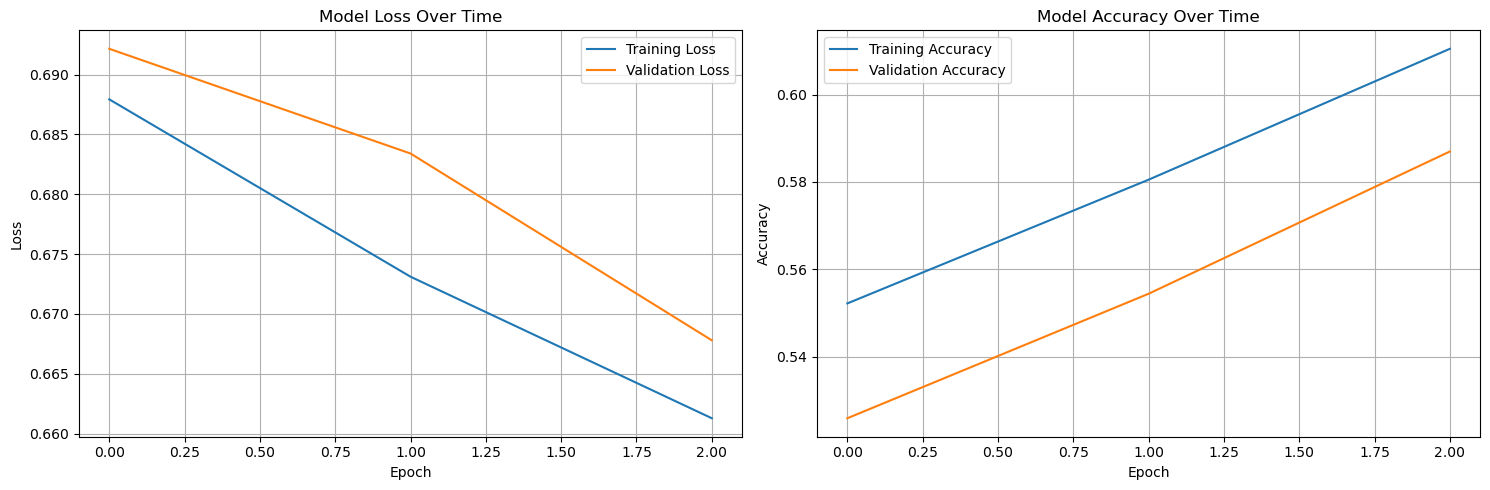


2. Analyzing predictions...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
current threshold:  0.45045674


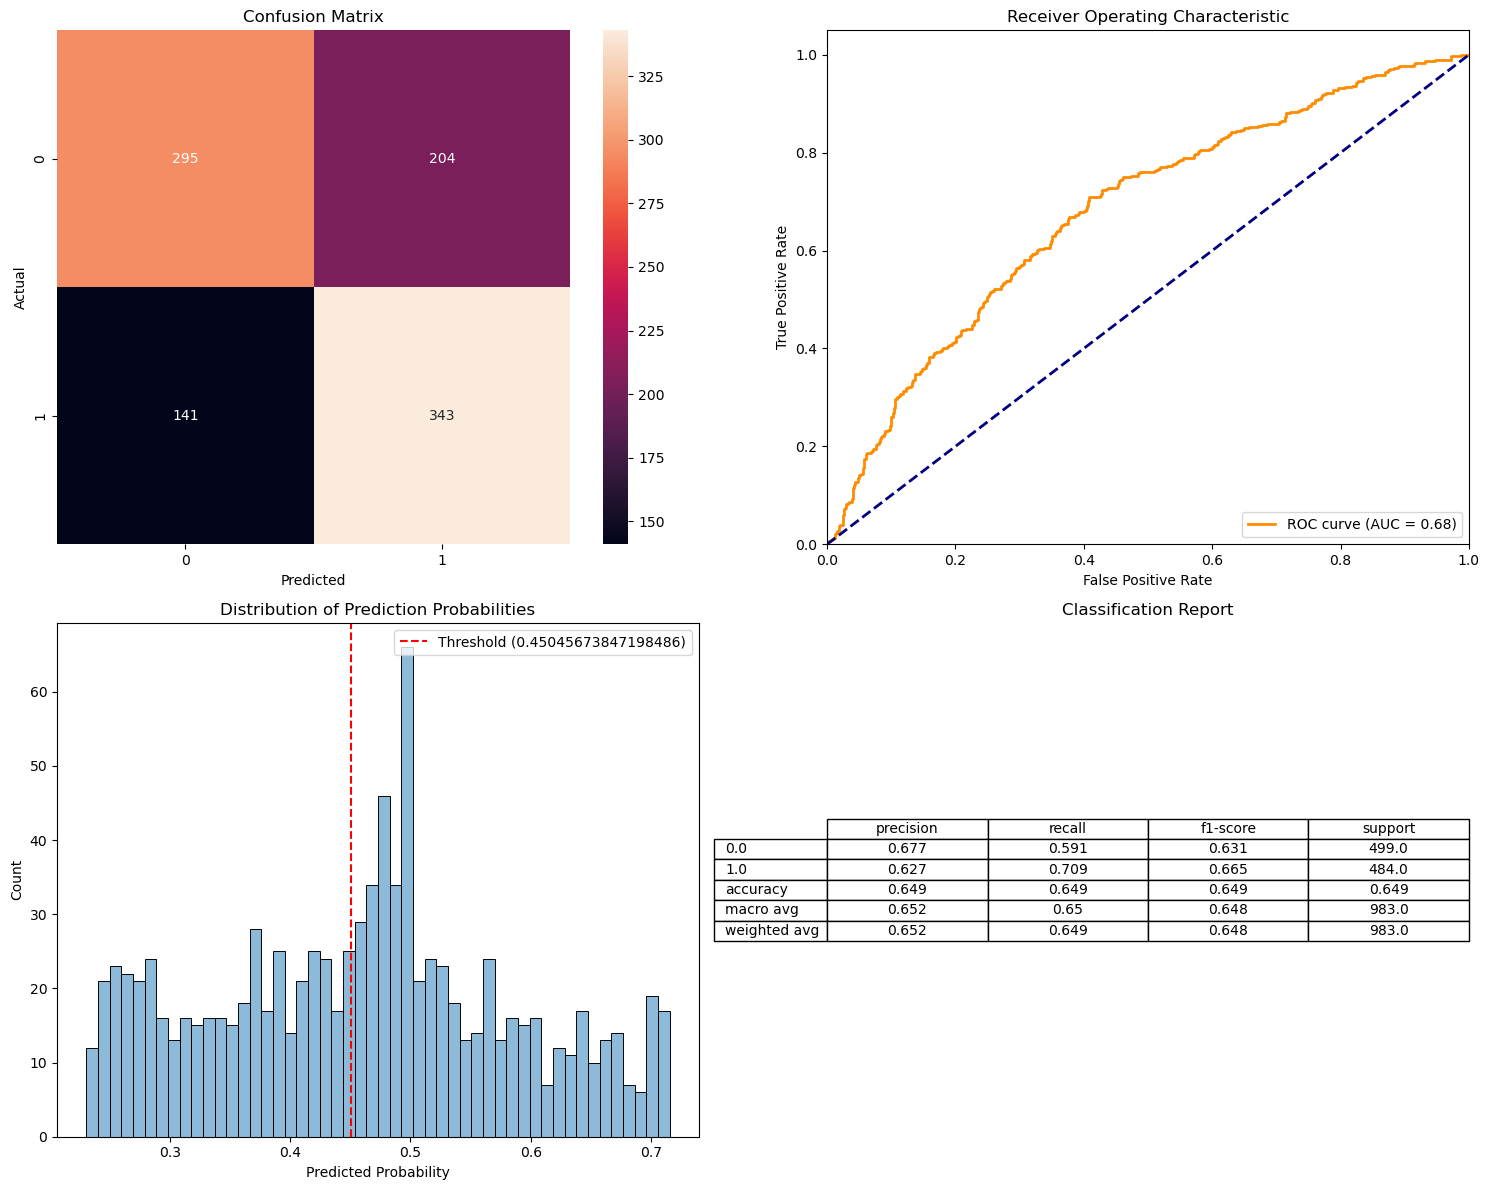


3. Analyzing prediction errors...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


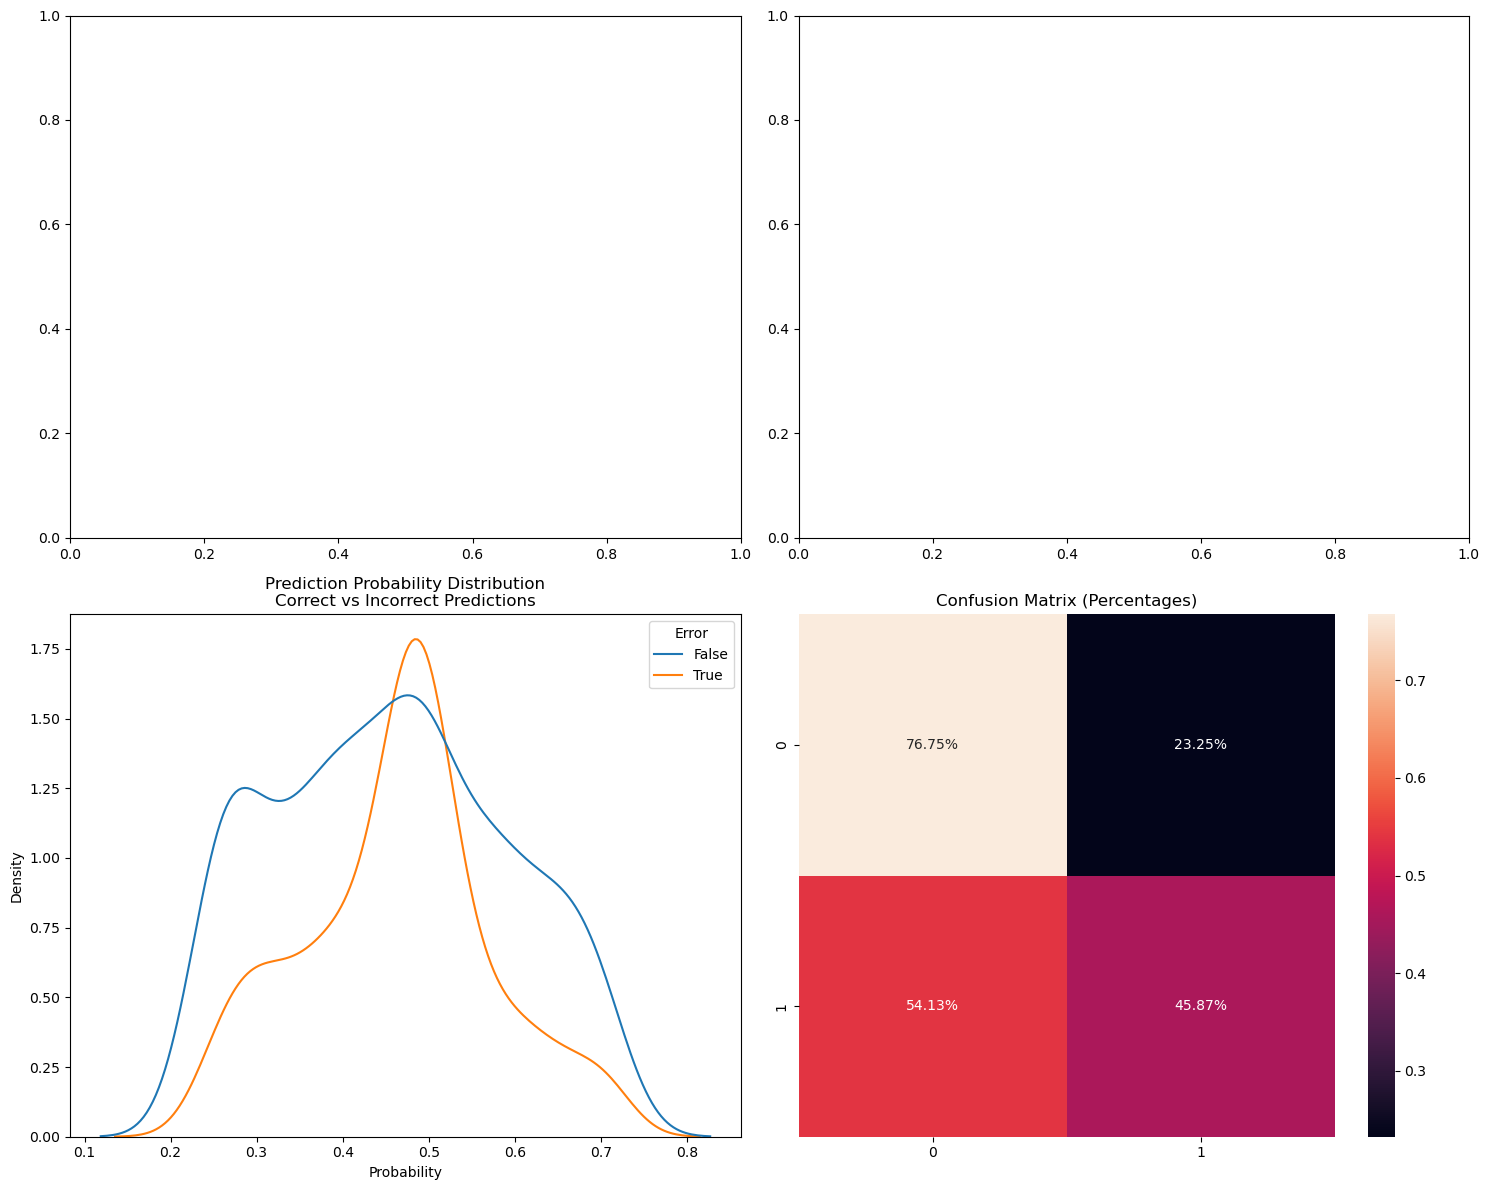


4. Evaluating prediction horizons...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


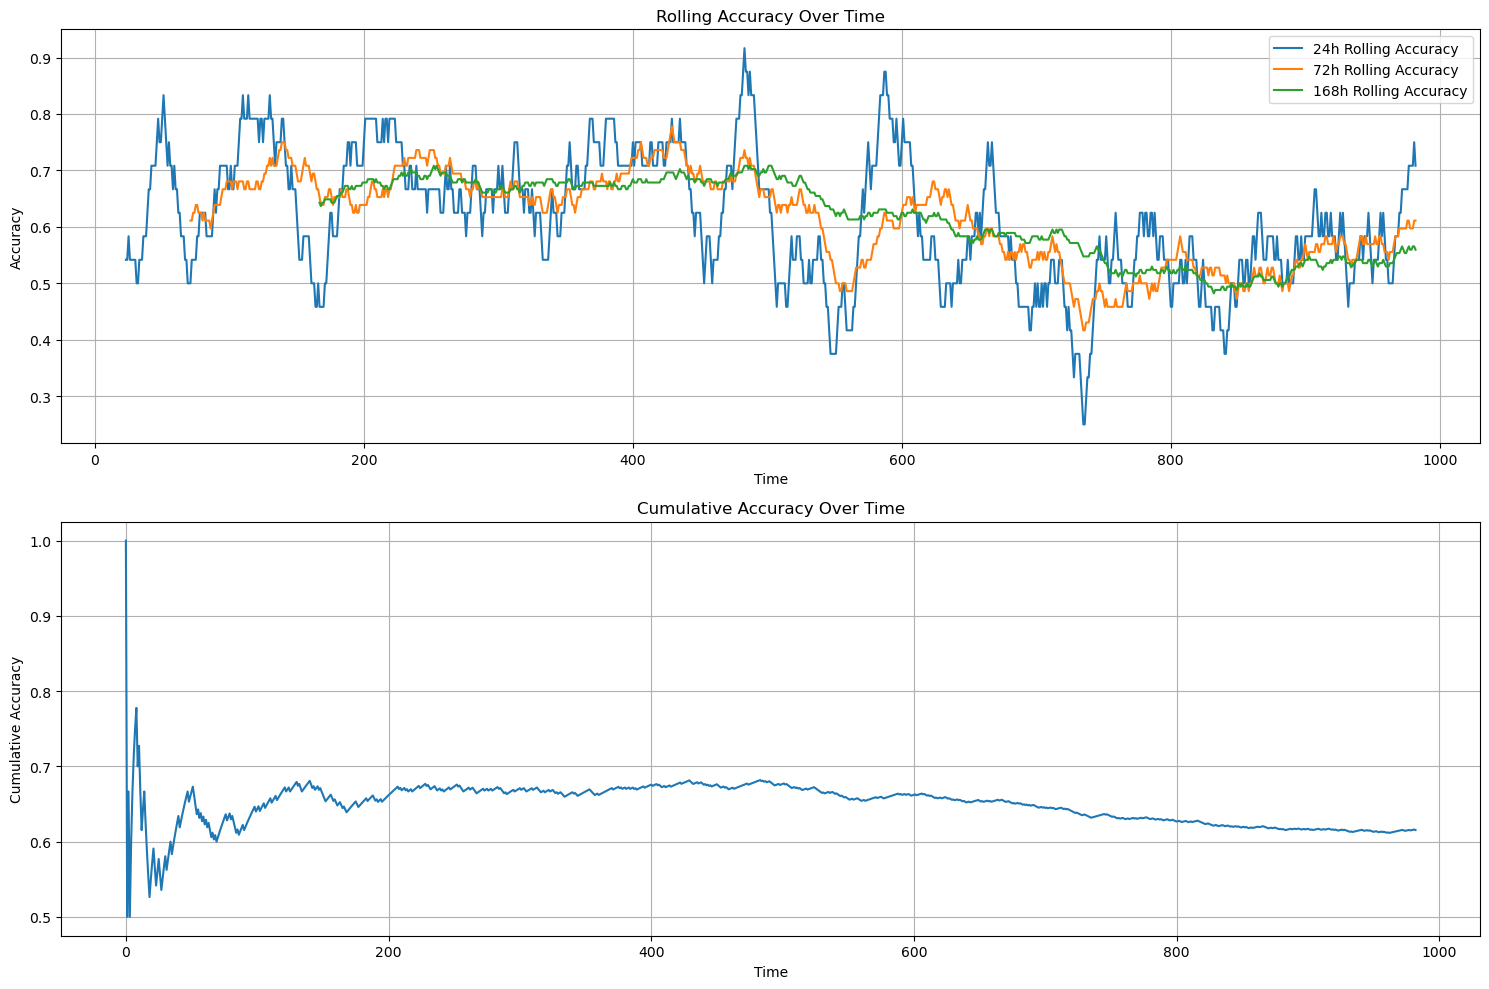

=== Comprehensive Model Analysis ===



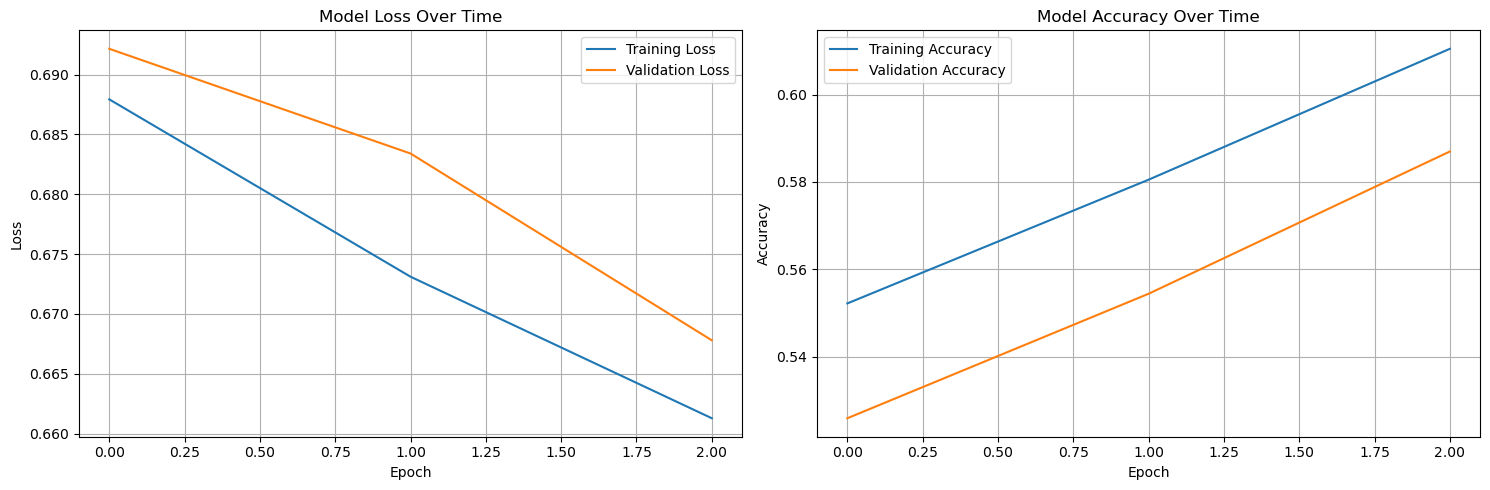

Training Pattern Analysis:
High training loss suggests underfitting. Consider:
- Increasing model capacity (add more layers/neurons)
- Training for more epochs
- Reducing regularization (lower dropout rate)

=== Classification Performance ===
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Performance Analysis:

AUC Score: 0.680
Low AUC suggests poor discriminative ability. Consider:
- Adding more relevant features
- Feature engineering
- Trying different model architectures

Sensitivity (True Positive Rate): 0.459
Specificity (True Negative Rate): 0.768

Imbalanced prediction performance detected. Consider:
- Class weighting in model
- Adjusting decision threshold
- Addressing data imbalance
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== Prediction Confidence Analysis ===


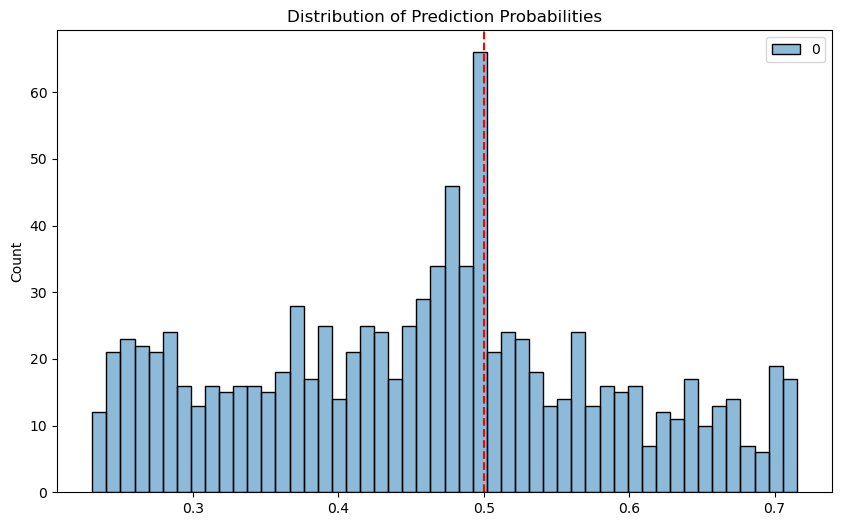

Prediction Confidence Analysis:
Proportion of low confidence predictions: 0.516

High proportion of low confidence predictions. Consider:
- Adding more discriminative features
- Increasing model capacity
- Using ensemble methods


In [80]:
# Clear the session to reset the model
backend.clear_session()

# Reset the global graph and free memory
# tf.compat.v1.reset_default_graph()

# Train model
start_mlflow_run(mlflow_run_name, n_trials, use_optuna = True, log_evaluation_period = 10)

#### 5.3.  Final training the model with the best params

In [81]:
# Analysis results
# analysis_results = perform_complete_analysis(model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)

In [82]:
# Performs comprehensive analysis and provides specific improvement recommendations
# comprehensive_model_analysis(model, X_test_seq, y_test_seq, history, btc_price_data_1_year)

## Tuning the right hyperparameters with **Optuna**

Since you're using a **CNN-LSTM hybrid model** for **Bitcoin price movement prediction**, tuning the right hyperparameters with **Optuna** can significantly improve performance. Here are the key hyperparameters to tune, categorized by **model architecture, training, and optimization**:

---

## **🔹 Key Hyperparameters to Tune**
### **1️⃣ Model Architecture (LSTM + CNN Layers)**
#### 🔥 **LSTM Hyperparameters**
- **Number of LSTM units** (`lstm_units`) → Controls memory capacity
  - Range: **32 - 512** (log scale works best)
  - Example: `trial.suggest_int("lstm_units", 32, 512, step=32)`

- **LSTM Dropout** (`lstm_dropout`) → Prevents overfitting
  - Range: **0.1 - 0.5**
  - Example: `trial.suggest_float("lstm_dropout", 0.1, 0.5)`

#### 🎯 **CNN Hyperparameters**
- **Number of CNN filters** (`cnn_filters`) → Extracts local patterns
  - Range: **8 - 128**
  - Example: `trial.suggest_int("cnn_filters", 8, 128, step=8)`

- **Kernel size** (`cnn_kernel_size`) → Determines receptive field
  - Range: **2 - 5**
  - Example: `trial.suggest_int("cnn_kernel_size", 2, 5)`

- **CNN Dropout** (`cnn_dropout`) → Prevents overfitting
  - Range: **0.1 - 0.5**
  - Example: `trial.suggest_float("cnn_dropout", 0.1, 0.5)`

---

### **2️⃣ Training Parameters**
#### 📊 **Batch Size (`batch_size`)**
- Controls gradient updates per step.
- Range: **16 - 512** (log scale works best)
- Example: `trial.suggest_int("batch_size", 16, 512, step=16)`

#### ⏳ **Sequence Length (`seq_length`)**
- Determines the number of past timesteps used for prediction.
- Range: **30 - 240** (multiples of 10)
- Example: `trial.suggest_int("seq_length", 30, 240, step=10)`

#### 🎭 **Number of Epochs (`epochs`)**
- More epochs allow better training but risk overfitting.
- Range: **20 - 200**
- Example: `trial.suggest_int("epochs", 20, 200, step=10)`

---

### **3️⃣ Optimization Parameters**
#### 🚀 **Learning Rate (`learning_rate`)**
- Controls how fast the model updates weights.
- Range: **1e-5 to 1e-2** (log scale)
- Example: `trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)`

#### 📉 **Optimizer Type (`optimizer`)**
- Different optimizers may perform better based on data.
- Choices: `['adam', 'sgd', 'rmsprop', 'nadam']`
- Example: `trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop", "nadam"])`

#### 🏋️ **Weight Decay (`weight_decay`)**
- Regularizes model to prevent overfitting.
- Range: **1e-6 to 1e-3**
- Example: `trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)`

#### 🔀 **Gradient Clipping (`clipnorm`)**
- Prevents exploding gradients in LSTMs.
- Range: **0.1 - 5**
- Example: `trial.suggest_float("clipnorm", 0.1, 5)`

---

## **🔥 Optuna Example: CNN-LSTM Hyperparameter Tuning**
Here’s how you can integrate Optuna for hyperparameter tuning:

```python
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout

def build_model(trial):
    # Suggest hyperparameters
    lstm_units = trial.suggest_int("lstm_units", 32, 512, step=32)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0.1, 0.5)
    cnn_filters = trial.suggest_int("cnn_filters", 8, 128, step=8)
    cnn_kernel_size = trial.suggest_int("cnn_kernel_size", 2, 5)
    cnn_dropout = trial.suggest_float("cnn_dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop", "nadam"])
    
    # Model definition
    model = Sequential([
        Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu', input_shape=(seq_length, num_features)),
        Dropout(cnn_dropout),
        LSTM(lstm_units, return_sequences=False),
        Dropout(lstm_dropout),
        Dense(1, activation='sigmoid')
    ])

    # Optimizer selection
    optimizer = getattr(tf.keras.optimizers, optimizer_name)(learning_rate=learning_rate)
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Define objective function
def objective(trial):
    model = build_model(trial)
    
    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)
    
    # Get validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
```

---

## **🔥 Best Practices for Tuning**
✔ **Use log scale for learning rate & batch size** → These values often vary exponentially.  
✔ **Use early stopping** → Prevents unnecessary long training.  
✔ **Optimize for `val_accuracy` or Sharpe Ratio** → Use a metric that best reflects trading success.  
✔ **Parallelize Optuna trials** → Speeds up the tuning process.  
✔ **Use a study sampler (`TPESampler`)** → Efficiently searches for optimal values.  

Would you like to integrate **Optuna with your reinforcement learning model** as well? 😊

To tune the hyperparameters of your CNN-LSTM model using Optuna, follow these steps:

---

### **1. Install Optuna (if not installed)**
```bash
pip install optuna
```

---

### **2. Define an Objective Function for Optuna**
This function will:
- Sample hyperparameters using Optuna.
- Create a CNN-LSTM model with those hyperparameters.
- Train and evaluate the model.
- Return the validation loss (or another metric) for optimization.

```python
import optuna
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=64)
    lstm_units_2 = trial.suggest_int("lstm_units_2", 64, 192, step=64)
    lstm_units_3 = trial.suggest_int("lstm_units_3", 64, 128, step=64)
    
    # Get input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create model with sampled hyperparameters
    model = create_cnn_lstm_model(input_shape, dropout_rate, lstm_units_1, lstm_units_2, lstm_units_3)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5),
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Use fewer epochs for faster tuning
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )
    
    # Return validation loss for optimization
    val_loss = min(history.history["val_loss"])
    return val_loss
```

---

### **3. Run Optuna Optimization**
```python
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create study
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print best parameters
print("Best hyperparameters:", study.best_params)
```

---

### **4. Train the Model with Best Hyperparameters**
Once Optuna finds the best parameters, train the final model with them:

```python
best_params = study.best_params
best_model = create_cnn_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]), 
    dropout_rate=best_params["dropout_rate"],
    lstm_units_1=best_params["lstm_units_1"],
    lstm_units_2=best_params["lstm_units_2"],
    lstm_units_3=best_params["lstm_units_3"]
)

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_params["batch_size"],
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
    ],
    verbose=1
)
```

---

This will fine-tune your model’s learning rate, dropout, batch size, and LSTM units, leading to better performance in predicting Bitcoin price movement.

### 10.5. Forecast Future Prices

Once the model is trained, you can use it to forecast future prices.

In [83]:
# # Prepare a sequence of the last 24 hours
# latest_sequence = X_test_seq[-1].reshape(1, sequence_length, num_features)

# # Predict the next hour's price
# next_price_scaled = model.predict(latest_sequence)
# print(f"Predicted next price: {next_price_scaled[0][0]}")

# # Prepare the input with the same number of features
# predicted_full_features = np.zeros((1, 55))  # Assuming 55 features in the original scaler
# predicted_full_features[:, -1] = next_price_scaled[0][0]  # Insert the predicted price

# # Inverse transform
# next_price_original_full = scaler.inverse_transform(predicted_full_features)

# # Extract the original price
# next_price_original = next_price_original_full[0, -1]
# print(f"Predicted next price (original scale): {next_price_original}")

Here’s a step-by-step guide on how to use your prepared dataset for training a neural network and tuning hyperparameters:

---
### **Step 6: Hyperparameter Tuning**
To tune hyperparameters, you can use tools like **Keras Tuner** or manually adjust parameters in a structured way.

### Option 1: Grid Search (Manual)
Manually try different combinations of hyperparameters:
- **Number of filters in CNN (e.g., 16, 32, 64).**
- **LSTM units (e.g., 32, 64, 128).**
- **Batch size (e.g., 16, 32, 64).**
- **Learning rate (e.g., 0.001, 0.0001).**
- **Dropout rate (e.g., 0.2, 0.3, 0.4).**

Example:
```python
for filters in [16, 32, 64]:
    for lstm_units in [32, 64, 128]:
        model = build_model(sequence_length, num_features)
        print(f"Training with filters={filters}, lstm_units={lstm_units}")
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
```

---

### Option 2: Keras Tuner (Automated)
Use **Keras Tuner** to automate hyperparameter tuning.

```python
import keras_tuner as kt

# Define a model-building function for Keras Tuner
def build_tuned_model(hp):
    input_layer = Input(shape=(sequence_length, num_features))
    
    # CNN
    cnn_layer = Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16), 
        kernel_size=3, activation='relu'
    )(input_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    # LSTM
    lstm_layer = LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
        return_sequences=False
    )(input_layer)
    
    # Combine
    combined = Concatenate()([cnn_layer, lstm_layer])
    dense_layer = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64), 
        activation='relu'
    )(combined)
    dense_layer = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(dense_layer)
    output_layer = Dense(1, activation='linear')(dense_layer)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='bitcoin_forecasting'
)

# Run the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")
```

---

### **Step 7: Save and Load the Model**
Save the best model for future use.

```python
# Save model
model.save('bitcoin_price_model.h5')

# Load model
from tensorflow.keras.models import load_model
model = load_model('bitcoin_price_model.h5')
```

---

### **Step 8: Forecast Future Prices**
Once the model is trained, you can use it to forecast future prices.

```python
# Prepare a sequence of the last 24 hours
latest_sequence = X_test[-1].reshape(1, sequence_length, num_features)

# Predict the next hour's price
next_price = model.predict(latest_sequence)
print(f"Predicted next price: {next_price[0][0]}")
```

---

This approach allows you to train, evaluate, and tune your model effectively. Let me know if you need more help!

## Resources

[1] Venujkvenk. (2023b, September 23). Exploring time series data: unveiling trends, seasonality, and residuals. Medium. https://medium.com/venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1

[2] Kis, A. (2024, November 19). Understanding autocorrelation and partial autocorrelation functions (ACF and PACF). Medium. https://medium.com/kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5

[3] Olamendy, J. C. (2025, January 17). Mastering feature scaling and normalization in machine learning. Medium. https://medium.com/juanc.olamendy/mastering-feature-scaling-and-normalization-in-machine-learning-985fdecfab5c

[4] Hamad, R. (2023, December 11). What is LSTM? Introduction to Long Short-Term Memory. Medium. https://medium.com/rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce